In [1]:
import tensorflow as tf
import pandas as pd
import os, time, itertools, imageio, pickle, random
import numpy as np
import matplotlib.pyplot as plt
import random
from utils import one_hot, resize_to_ori_calMRE, resize_to_ori


tf.reset_default_graph() 
os.environ["CUDA_VISIBLE_DEVICES"] = "0" # select GPU

C:\Users\WIN10\anaconda3\envs\tf1.12\lib\site-packages\tensorflow\python\framework\dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\WIN10\anaconda3\envs\tf1.12\lib\site-packages\tensorflow\python\framework\dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\WIN10\anaconda3\envs\tf1.12\lib\site-packages\tensorflow\python\framework\dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\WIN10\anaconda3\envs\tf1.12\lib\site-packages\tensorflow\pyth

In [2]:
folder = 'election_VAE_alt4/'
gen_results = 'generated_results/'

model = 'model_'+'.ckpt'

if not os.path.isdir(folder):
    os.mkdir(folder)
    
if not os.path.isdir(folder + gen_results):
    os.mkdir(folder + gen_results)

# save ckpt
saver_path = os.path.join(folder, model)

# read ckpt
restore_path = os.path.join(folder)

# save generated data
generated_path = os.path.join(folder + gen_results)

In [3]:
# one hot code
def one_hot ( labels , Label_class ): 
    one_hot_label = np.array([[ int (i == int (labels[j])) for i in range (Label_class)] for j in range ( len (labels))])      
    return one_hot_label

In [4]:
img_width = 30
img_height = 24

data_alt3 = pd.read_csv('./data/netflix_data_3alt_resize.csv')
data_alt3 = data_alt3.iloc[:1000,1:].values

data_alt3 = data_alt3.reshape([-1, img_height, img_width])
print(data_alt3.shape)

##################################
data_alt4 = pd.read_csv('./data/netflix_data_4alt_resize.csv')
data_alt4 = data_alt4.iloc[:1000,1:].values

data_alt4 = data_alt4.reshape([-1, img_height, img_width])
print(data_alt4.shape)


data_alt_3_4 = data_alt4

(1000, 24, 30)
(1000, 24, 30)


In [5]:
# fig, ax = plt.subplots(figsize=(5, 5))
# ax.cla()
# ax.imshow(np.reshape(data_alt3[2], (data_alt3.shape[1], data_alt3.shape[2])), cmap='gray')

# fig, ax = plt.subplots(figsize=(5, 5))
# ax.cla()
# ax.imshow(np.reshape(data_alt4[99], (data_alt3.shape[1], data_alt3.shape[2])), cmap='gray')

In [6]:
np.random.seed(0)
np.random.shuffle(data_alt_3_4)

In [7]:
class election_VAE(object):
    def __init__(self,
                num_samples = None,
                dim_height = None,
                dim_width = None,
                dim_z = None,
                num_class = None,
                batch_size = None,
                _reuse = None):
        
        # Definition Params:
        self.num_samples = num_samples  
        self.dim_height = dim_height    
        self.dim_width = dim_width  
        self.dim_z = dim_z    
        self.num_class = num_class      
        self.batch_size = batch_size  

        # Define Network Input:
        self.X = tf.placeholder(tf.float32, shape=(self.batch_size, self.dim_height, self.dim_width, 1))
#         self.Z = tf.placeholder(tf.float32, shape=(self.batch_size, 1, 1, self.dim_z))
        self.Z = tf.placeholder(tf.float32, shape=(self.batch_size*self.dim_z))
        self.Y_label = tf.placeholder(tf.float32, shape=(self.batch_size, 1, 1, self.num_class))
        self.Y_fill = tf.placeholder(tf.float32, shape=(self.batch_size, self.dim_height, self.dim_width, self.num_class))
        self.isTrain = tf.placeholder(dtype=tf.bool)
        self.keep_prob_feed = tf.placeholder(tf.float32)
        self.global_step = tf.Variable(0, trainable = False)
        
        # Network:
        self._decoder(self.Z, self.keep_prob_feed)
        
        self._encoder(self.X, self.keep_prob_feed)
        
        with tf.variable_scope('object_cost_function', reuse=tf.AUTO_REUSE):
            self._object_cost_function()        
        
    def _decoder(self, Z, keep_prob_feed):

        with tf.variable_scope("decoder", reuse=tf.AUTO_REUSE):
            dim = 128

            # concat layer
#             Z_ = tf.concat([Z, Y_label], 3)  #(batch_szie, 1, 1, dim_z + num_class)
            Z_ = tf.reshape(Z, (-1, self.dim_z))        

            # FCN 
            hidden = tf.layers.dense(Z_, units = 2*2*3*dim)
#             hidden = tf.layers.batch_normalization(hidden, training=isTrain)
            hidden = tf.nn.relu(hidden)
            hidden = tf.reshape(hidden, (-1, 2, 2, 3*dim)) 

            # CNN 1 
            hidden = tf.layers.conv2d_transpose(hidden, 2*dim, [3, 3], strides=(1, 2), padding='valid')
#             hidden = tf.layers.batch_normalization(hidden, training=isTrain)
            hidden = tf.nn.relu(hidden)

            # CNN 2 
            hidden = tf.layers.conv2d_transpose(hidden, 1*dim, [3, 3], strides=(3, 3), padding='same')
#             hidden = tf.layers.batch_normalization(hidden, training=isTrain)
            hidden = tf.nn.relu(hidden)     

            # CNN 3 
            hidden = tf.layers.conv2d_transpose(hidden, 1, [3, 3], strides=(2, 2), padding='same')         
            output = hidden

            return output     
    
    def _encoder(self, X, keep_prob_feed):

        with tf.variable_scope("encoder", reuse=tf.AUTO_REUSE):
            dim = 128
            leak = 0.2
            # concat layer
#             X_ = tf.concat([X, Y_fill], 3)  #(batch_size, dim_height, dim_width, channel + num_class)
            X_ = X

            # CNN 1 
            hidden = tf.layers.conv2d(X_, 1*dim, [4, 5], strides=(2, 2), padding='same', use_bias=False)
            hidden = ((0.5 * (1 + leak)) * hidden) + ((0.5 * (1 - leak)) * tf.abs(hidden)) #lrelu

            # CNN 2 
            hidden = tf.layers.conv2d(hidden, 2*dim, [4, 5], strides=(2, 2), padding='same', use_bias=False)
            hidden = ((0.5 * (1 + leak)) * hidden) + ((0.5 * (1 - leak)) * tf.abs(hidden)) #lrelu

            # CNN 3
            hidden = tf.layers.conv2d(hidden, 2*dim, [4, 5], strides=(2, 2), padding='same', use_bias=False)
            hidden = ((0.5 * (1 + leak)) * hidden) + ((0.5 * (1 - leak)) * tf.abs(hidden)) #lrelu

            # Flatten layer
            hidden = tf.layers.flatten(hidden)        
            hidden = tf.layers.dense(hidden, units = self.dim_z)
            hidden = tf.reshape(hidden, (-1, 1)) 
#             print(hidden.shape)
            
            mean = hidden
            std = tf.nn.softplus(hidden) + 1e-6            

            return mean, std    
    
    def _object_cost_function(self):
        
        # MODEL
        mean, std = self._encoder(self.X, self.keep_prob_feed)

        eps = tf.random_normal(tf.shape(mean, out_type = tf.int32), 0, 1, dtype = tf.float32)
        self.Z = mean + std*eps  
        print(self.Z.shape)
        
        generated_output = self._decoder(self.Z, self.keep_prob_feed)
        
        self.real_data = self.X
        self.fake_data = generated_output
            
        # Recon_error
        self.Recon_error = tf.losses.mean_squared_error(self.real_data, self.fake_data)

        # KL_divergence
        KL_Divergence = tf.reduce_mean(0.5*tf.reduce_sum(1 - tf.log(tf.square(std) + 1e-8) 
                                                         + tf.square(mean) + tf.square(std), 1))
        Regularization_error = KL_Divergence

        # ELBO_error
        self.ELBO = self.Recon_error + Regularization_error
        
        learning_rate = 0.0001
        self.optim = tf.train.AdamOptimizer(learning_rate).minimize(self.ELBO)
        
            
    def train_model(self,
                    x_train = None,     
                    keep_prob = None,
                    train_epoch = None, 
                    n_critic = 5,
                    step_valid = 50,
                    step_save_data = 500, #500
                    iteration_generator = 50,
                   ): 
        
        self.train_hist = {}
        self.train_hist['Recon_e_list'] = []
        self.train_hist['ELBO_e_list'] = []

        saver = tf.train.Saver()
        
        session_config = tf.ConfigProto(gpu_options = tf.GPUOptions(allow_growth=True))
        with tf.Session(config = session_config) as sess:
            sess.run(tf.global_variables_initializer())
            print('Optimization start!')

            for epoch in range(train_epoch):
                Recon_e_list = []
                ELBO_e_list = []

                time_start_epoch = time.time()
                
                for i in range(len(x_train) // self.batch_size): # num_samples / batch_size
                    '''#############        Discriminator       #######################'''
                    x_ = x_train[i*self.batch_size: (i+1)*self.batch_size] 
                    x_ = x_.reshape((self.batch_size, self.dim_height, self.dim_width, 1))   #(batch_size, dim_height, dim_width, 1)

                    _, ELBO, Recon_error  = sess.run([self.optim, self.ELBO, self.Recon_error], 
                                          feed_dict={self.X: x_, 
                                                     self.keep_prob_feed: keep_prob,
                                                     self.isTrain: True})
                    ELBO_e_list.append(ELBO)
                    Recon_e_list.append(Recon_error)

            ############        print result      #######################
                if (epoch+1) % 1 == 0:
                    print('[%d/%d] Recon_e: %.3f, ELBO_e: %.3f'%((epoch + 1), train_epoch, np.mean(ELBO_e_list), np.mean(Recon_e_list)))
                    self.train_hist['Recon_e_list'].append(np.mean(ELBO_e_list))
                    self.train_hist['ELBO_e_list'].append(np.mean(Recon_e_list))

            ############        valid      #######################
                if (epoch+1) % step_valid == 0:
                    z_ = np.random.normal(0, 1, (self.batch_size, 1, 1, self.dim_z)).reshape([-1,1]) 

                    output_g_alt = sess.run([self.fake_data], 
                                          feed_dict={self.Z: z_, 
                                                     self.keep_prob_feed: 1,
                                                     self.isTrain: False})    
                    output_g_alt_ = np.array(output_g_alt).reshape([self.batch_size, self.dim_height, self.dim_width])[0]

                    plt.figure(epoch)
                    fig, ax = plt.subplots(figsize=(5, 5))
                    ax.cla()
                    ax.imshow(np.reshape(output_g_alt_, (self.dim_height, self.dim_width)), cmap='gray')

            ############        save per 1000 epoch      #######################
                if (epoch+1) % step_save_data == 0:
                    
                    generated_alt = []
                    for _ in range(iteration_generator):  
                        z_ = np.random.normal(0, 1, (self.batch_size, 1, 1, self.dim_z)).reshape([-1,1]) 

                        output_g_alt = sess.run([self.fake_data], 
                                                        feed_dict={self.Z: z_, 
                                                        self.keep_prob_feed: 1,
                                                        self.isTrain: False})    
                        generated_alt.append(np.array(output_g_alt).reshape([self.batch_size, self.dim_height, self.dim_width]))

                    generated_alt = np.array(generated_alt).reshape([iteration_generator*self.batch_size, self.dim_height, self.dim_width])
                  
                    gen_alt_ori = resize_to_ori(generated_alt, np.math.factorial(6), 30, 24, np.math.factorial(4), self.batch_size, iteration_generator)
                    gen_alt_pd = pd.DataFrame(gen_alt_ori, columns = ['ABCD', 'ACBD', 'BACD', 'BCAD', 'CABD', 'CBAD', 'DABC',
                           'DACB', 'DBAC', 'DBCA', 'DCAB', 'DCBA', 'ADBC', 'ADCB', 'BDAC', 'BDCA',
                           'CDAB', 'CDBA', 'ABDC', 'ACDB', 'BADC', 'BCDA', 'CADB', 'CBDA'])
                    gen_alt_pd.to_csv(generated_path + 'generated_atl4_' + str(epoch) + '.csv')                    
                    
                time_end_epoch = time.time()
                print('Time cost in one epoch', time_end_epoch - time_start_epoch,'s') 
                    
            ###########        save      #######################
            saver.save(sess, saver_path)   
            print('save success')
        
            sess.close()

        print("Optimization Finished!")
        
    '''loss curve'''
    def show_train_hist(self):
        x = range(len(self.train_hist['Recon_e_list']))

        y1 = self.train_hist['Recon_e_list']
        y2 = self.train_hist['ELBO_e_list']

        plt.plot(x, y1, label='Recon_e_list')
        plt.plot(x, y2, label='ELBO_e_list')

        plt.xlabel('Epoch')
        plt.ylabel('Loss')

        plt.legend(loc=4)  
        plt.grid(True)
        plt.tight_layout() 
        plt.title("Training Losses")

        plt.show()


In [8]:
num_samples = data_alt_3_4.shape[0]
dim_height = data_alt_3_4.shape[1]
dim_width = data_alt_3_4.shape[2]
dim_z = 128
num_class = 2
batch_size = 50

In [9]:
model = election_VAE(
                num_samples = num_samples,
                dim_height = dim_height,
                dim_width = dim_width,
                dim_z = dim_z,
                num_class = num_class,
                batch_size = batch_size)


(6400, 1)


Optimization start!
[1/5000] Recon_e: 1.095, ELBO_e: 0.003
Time cost in one epoch 4.895909547805786 s
[2/5000] Recon_e: 1.068, ELBO_e: 0.003
Time cost in one epoch 0.46874547004699707 s
[3/5000] Recon_e: 1.066, ELBO_e: 0.002
Time cost in one epoch 1.8490567207336426 s
[4/5000] Recon_e: 1.066, ELBO_e: 0.002
Time cost in one epoch 0.48171210289001465 s
[5/5000] Recon_e: 1.066, ELBO_e: 0.002
Time cost in one epoch 1.777249813079834 s
[6/5000] Recon_e: 1.066, ELBO_e: 0.002
Time cost in one epoch 0.4777209758758545 s
[7/5000] Recon_e: 1.065, ELBO_e: 0.002
Time cost in one epoch 0.44281864166259766 s
[8/5000] Recon_e: 1.065, ELBO_e: 0.002
Time cost in one epoch 1.8201313018798828 s
[9/5000] Recon_e: 1.065, ELBO_e: 0.002
Time cost in one epoch 0.4418201446533203 s
[10/5000] Recon_e: 1.065, ELBO_e: 0.002
Time cost in one epoch 1.8460638523101807 s
[11/5000] Recon_e: 1.065, ELBO_e: 0.002
Time cost in one epoch 0.47373390197753906 s
[12/5000] Recon_e: 1.065, ELBO_e: 0.002
Time cost in one epoch 

[99/5000] Recon_e: 1.065, ELBO_e: 0.002
Time cost in one epoch 1.8869531154632568 s
[100/5000] Recon_e: 1.065, ELBO_e: 0.002
Time cost in one epoch 0.499664306640625 s
[101/5000] Recon_e: 1.065, ELBO_e: 0.002
Time cost in one epoch 1.896928310394287 s
[102/5000] Recon_e: 1.065, ELBO_e: 0.002
Time cost in one epoch 0.4667527675628662 s
[103/5000] Recon_e: 1.065, ELBO_e: 0.002
Time cost in one epoch 1.7981932163238525 s
[104/5000] Recon_e: 1.065, ELBO_e: 0.002
Time cost in one epoch 0.4866979122161865 s
[105/5000] Recon_e: 1.065, ELBO_e: 0.002
Time cost in one epoch 1.807168960571289 s
[106/5000] Recon_e: 1.065, ELBO_e: 0.002
Time cost in one epoch 0.48769664764404297 s
[107/5000] Recon_e: 1.065, ELBO_e: 0.002
Time cost in one epoch 0.4497971534729004 s
[108/5000] Recon_e: 1.065, ELBO_e: 0.002
Time cost in one epoch 1.8909425735473633 s
[109/5000] Recon_e: 1.065, ELBO_e: 0.002
Time cost in one epoch 0.4607689380645752 s
[110/5000] Recon_e: 1.065, ELBO_e: 0.002
Time cost in one epoch 1.79

[196/5000] Recon_e: 1.065, ELBO_e: 0.002
Time cost in one epoch 1.8789746761322021 s
[197/5000] Recon_e: 1.065, ELBO_e: 0.002
Time cost in one epoch 0.4577763080596924 s
[198/5000] Recon_e: 1.065, ELBO_e: 0.002
Time cost in one epoch 1.7991902828216553 s
[199/5000] Recon_e: 1.065, ELBO_e: 0.002
Time cost in one epoch 0.4717404842376709 s
[200/5000] Recon_e: 1.065, ELBO_e: 0.002
Time cost in one epoch 1.8460631370544434 s
[201/5000] Recon_e: 1.065, ELBO_e: 0.002
Time cost in one epoch 0.475726842880249 s
[202/5000] Recon_e: 1.065, ELBO_e: 0.002
Time cost in one epoch 1.8201348781585693 s
[203/5000] Recon_e: 1.065, ELBO_e: 0.002
Time cost in one epoch 0.5016574859619141 s
[204/5000] Recon_e: 1.065, ELBO_e: 0.002
Time cost in one epoch 1.7862255573272705 s
[205/5000] Recon_e: 1.065, ELBO_e: 0.002
Time cost in one epoch 0.4837074279785156 s
[206/5000] Recon_e: 1.065, ELBO_e: 0.002
Time cost in one epoch 0.4617645740509033 s
[207/5000] Recon_e: 1.065, ELBO_e: 0.002
Time cost in one epoch 1.

[293/5000] Recon_e: 1.065, ELBO_e: 0.002
Time cost in one epoch 0.4807147979736328 s
[294/5000] Recon_e: 1.065, ELBO_e: 0.002
Time cost in one epoch 1.79022216796875 s
[295/5000] Recon_e: 1.065, ELBO_e: 0.002
Time cost in one epoch 0.49666333198547363 s
[296/5000] Recon_e: 1.065, ELBO_e: 0.002
Time cost in one epoch 1.786224126815796 s
[297/5000] Recon_e: 1.065, ELBO_e: 0.002
Time cost in one epoch 0.5036544799804688 s
[298/5000] Recon_e: 1.065, ELBO_e: 0.002
Time cost in one epoch 1.793205976486206 s
[299/5000] Recon_e: 1.065, ELBO_e: 0.002
Time cost in one epoch 0.5016574859619141 s
[300/5000] Recon_e: 1.065, ELBO_e: 0.002
Time cost in one epoch 0.4916858673095703 s
[301/5000] Recon_e: 1.065, ELBO_e: 0.002
Time cost in one epoch 1.912886142730713 s
[302/5000] Recon_e: 1.065, ELBO_e: 0.002
Time cost in one epoch 0.4607667922973633 s
[303/5000] Recon_e: 1.065, ELBO_e: 0.002
Time cost in one epoch 1.8823394775390625 s
[304/5000] Recon_e: 1.065, ELBO_e: 0.002
Time cost in one epoch 0.457

[390/5000] Recon_e: 1.065, ELBO_e: 0.002
Time cost in one epoch 1.8004348278045654 s
[391/5000] Recon_e: 1.065, ELBO_e: 0.002
Time cost in one epoch 0.4771604537963867 s
[392/5000] Recon_e: 1.065, ELBO_e: 0.002
Time cost in one epoch 1.8498129844665527 s
[393/5000] Recon_e: 1.065, ELBO_e: 0.002
Time cost in one epoch 0.49240565299987793 s
[394/5000] Recon_e: 1.065, ELBO_e: 0.002
Time cost in one epoch 0.44880032539367676 s
[395/5000] Recon_e: 1.065, ELBO_e: 0.002
Time cost in one epoch 1.9094595909118652 s
[396/5000] Recon_e: 1.065, ELBO_e: 0.002
Time cost in one epoch 0.4559600353240967 s
[397/5000] Recon_e: 1.065, ELBO_e: 0.002
Time cost in one epoch 1.9064264297485352 s
[398/5000] Recon_e: 1.065, ELBO_e: 0.002
Time cost in one epoch 0.46977996826171875 s
[399/5000] Recon_e: 1.065, ELBO_e: 0.002
Time cost in one epoch 1.8321690559387207 s
[400/5000] Recon_e: 1.065, ELBO_e: 0.002
Time cost in one epoch 0.5337269306182861 s
[401/5000] Recon_e: 1.065, ELBO_e: 0.002
Time cost in one epoc

[487/5000] Recon_e: 1.065, ELBO_e: 0.002
Time cost in one epoch 1.8312907218933105 s
[488/5000] Recon_e: 1.065, ELBO_e: 0.002
Time cost in one epoch 0.5016574859619141 s
[489/5000] Recon_e: 1.065, ELBO_e: 0.002
Time cost in one epoch 0.45079469680786133 s
[490/5000] Recon_e: 1.065, ELBO_e: 0.002
Time cost in one epoch 1.835254192352295 s
[491/5000] Recon_e: 1.065, ELBO_e: 0.002
Time cost in one epoch 0.4617655277252197 s
[492/5000] Recon_e: 1.065, ELBO_e: 0.002
Time cost in one epoch 1.900148630142212 s
[493/5000] Recon_e: 1.065, ELBO_e: 0.002
Time cost in one epoch 0.485701322555542 s
[494/5000] Recon_e: 1.065, ELBO_e: 0.002
Time cost in one epoch 1.8831310272216797 s
[495/5000] Recon_e: 1.065, ELBO_e: 0.002
Time cost in one epoch 0.49068665504455566 s
[496/5000] Recon_e: 1.065, ELBO_e: 0.002
Time cost in one epoch 1.8931999206542969 s
[497/5000] Recon_e: 1.065, ELBO_e: 0.002
Time cost in one epoch 0.5007905960083008 s
[498/5000] Recon_e: 1.065, ELBO_e: 0.002
Time cost in one epoch 0.

C:\Users\WIN10\anaconda3\envs\tf1.12\lib\site-packages\ipykernel_launcher.py:184: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


[551/5000] Recon_e: 1.065, ELBO_e: 0.002
Time cost in one epoch 1.8395414352416992 s
[552/5000] Recon_e: 1.065, ELBO_e: 0.002
Time cost in one epoch 0.4577817916870117 s
[553/5000] Recon_e: 1.065, ELBO_e: 0.002
Time cost in one epoch 1.86433744430542 s
[554/5000] Recon_e: 1.065, ELBO_e: 0.002
Time cost in one epoch 0.48769688606262207 s
[555/5000] Recon_e: 1.065, ELBO_e: 0.002
Time cost in one epoch 1.9111435413360596 s
[556/5000] Recon_e: 1.065, ELBO_e: 0.002
Time cost in one epoch 0.49467921257019043 s
[557/5000] Recon_e: 1.065, ELBO_e: 0.002
Time cost in one epoch 1.826192855834961 s
[558/5000] Recon_e: 1.065, ELBO_e: 0.002
Time cost in one epoch 0.5179226398468018 s
[559/5000] Recon_e: 1.065, ELBO_e: 0.002
Time cost in one epoch 0.4509916305541992 s
[560/5000] Recon_e: 1.065, ELBO_e: 0.002
Time cost in one epoch 1.8361616134643555 s
[561/5000] Recon_e: 1.065, ELBO_e: 0.002
Time cost in one epoch 0.4687459468841553 s
[562/5000] Recon_e: 1.065, ELBO_e: 0.002
Time cost in one epoch 1.

[648/5000] Recon_e: 1.065, ELBO_e: 0.002
Time cost in one epoch 0.5117616653442383 s
[649/5000] Recon_e: 1.065, ELBO_e: 0.002
Time cost in one epoch 0.4697437286376953 s
[650/5000] Recon_e: 1.065, ELBO_e: 0.002
Time cost in one epoch 1.9219598770141602 s
[651/5000] Recon_e: 1.065, ELBO_e: 0.002
Time cost in one epoch 0.4598543643951416 s
[652/5000] Recon_e: 1.065, ELBO_e: 0.002
Time cost in one epoch 1.855039119720459 s
[653/5000] Recon_e: 1.065, ELBO_e: 0.002
Time cost in one epoch 0.48009610176086426 s
[654/5000] Recon_e: 1.065, ELBO_e: 0.002
Time cost in one epoch 1.8510522842407227 s
[655/5000] Recon_e: 1.065, ELBO_e: 0.002
Time cost in one epoch 0.4827089309692383 s
[656/5000] Recon_e: 1.065, ELBO_e: 0.002
Time cost in one epoch 1.8370907306671143 s
[657/5000] Recon_e: 1.065, ELBO_e: 0.002
Time cost in one epoch 0.49567151069641113 s
[658/5000] Recon_e: 1.065, ELBO_e: 0.002
Time cost in one epoch 1.9073305130004883 s
[659/5000] Recon_e: 1.065, ELBO_e: 0.002
Time cost in one epoch 

[745/5000] Recon_e: 1.065, ELBO_e: 0.002
Time cost in one epoch 2.4045705795288086 s
[746/5000] Recon_e: 1.065, ELBO_e: 0.002
Time cost in one epoch 0.5106418132781982 s
[747/5000] Recon_e: 1.065, ELBO_e: 0.002
Time cost in one epoch 2.392592430114746 s
[748/5000] Recon_e: 1.065, ELBO_e: 0.002
Time cost in one epoch 0.505650520324707 s
[749/5000] Recon_e: 1.065, ELBO_e: 0.002
Time cost in one epoch 2.3098223209381104 s
[750/5000] Recon_e: 1.065, ELBO_e: 0.002
Time cost in one epoch 0.7390248775482178 s
[751/5000] Recon_e: 1.065, ELBO_e: 0.002
Time cost in one epoch 2.2629506587982178 s
[752/5000] Recon_e: 1.065, ELBO_e: 0.002
Time cost in one epoch 0.505648136138916 s
[753/5000] Recon_e: 1.065, ELBO_e: 0.002
Time cost in one epoch 2.3596882820129395 s
[754/5000] Recon_e: 1.065, ELBO_e: 0.002
Time cost in one epoch 0.5106303691864014 s
[755/5000] Recon_e: 1.065, ELBO_e: 0.002
Time cost in one epoch 2.3168060779571533 s
[756/5000] Recon_e: 1.065, ELBO_e: 0.002
Time cost in one epoch 0.50

[842/5000] Recon_e: 1.065, ELBO_e: 0.002
Time cost in one epoch 2.4025754928588867 s
[843/5000] Recon_e: 1.065, ELBO_e: 0.002
Time cost in one epoch 0.5016505718231201 s
[844/5000] Recon_e: 1.065, ELBO_e: 0.002
Time cost in one epoch 2.351407051086426 s
[845/5000] Recon_e: 1.065, ELBO_e: 0.002
Time cost in one epoch 0.5009288787841797 s
[846/5000] Recon_e: 1.065, ELBO_e: 0.002
Time cost in one epoch 2.36966609954834 s
[847/5000] Recon_e: 1.065, ELBO_e: 0.002
Time cost in one epoch 0.5006616115570068 s
[848/5000] Recon_e: 1.065, ELBO_e: 0.002
Time cost in one epoch 2.3600857257843018 s
[849/5000] Recon_e: 1.065, ELBO_e: 0.002
Time cost in one epoch 0.5156052112579346 s
[850/5000] Recon_e: 1.065, ELBO_e: 0.002
Time cost in one epoch 2.478714942932129 s
[851/5000] Recon_e: 1.065, ELBO_e: 0.002
Time cost in one epoch 2.234370231628418 s
[852/5000] Recon_e: 1.065, ELBO_e: 0.002
Time cost in one epoch 0.590411901473999 s
[853/5000] Recon_e: 1.065, ELBO_e: 0.002
Time cost in one epoch 2.31204

[939/5000] Recon_e: 1.065, ELBO_e: 0.002
Time cost in one epoch 0.4887821674346924 s
[940/5000] Recon_e: 1.065, ELBO_e: 0.002
Time cost in one epoch 0.44880008697509766 s
[941/5000] Recon_e: 1.065, ELBO_e: 0.002
Time cost in one epoch 1.835986614227295 s
[942/5000] Recon_e: 1.065, ELBO_e: 0.002
Time cost in one epoch 0.4511988162994385 s
[943/5000] Recon_e: 1.065, ELBO_e: 0.002
Time cost in one epoch 1.8642210960388184 s
[944/5000] Recon_e: 1.065, ELBO_e: 0.002
Time cost in one epoch 0.47373104095458984 s
[945/5000] Recon_e: 1.065, ELBO_e: 0.002
Time cost in one epoch 1.8700006008148193 s
[946/5000] Recon_e: 1.065, ELBO_e: 0.002
Time cost in one epoch 0.4817783832550049 s
[947/5000] Recon_e: 1.065, ELBO_e: 0.002
Time cost in one epoch 1.844069480895996 s
[948/5000] Recon_e: 1.065, ELBO_e: 0.002
Time cost in one epoch 0.4980137348175049 s
[949/5000] Recon_e: 1.065, ELBO_e: 0.002
Time cost in one epoch 0.44381213188171387 s
[950/5000] Recon_e: 1.065, ELBO_e: 0.002
Time cost in one epoch 

[1035/5000] Recon_e: 1.065, ELBO_e: 0.002
Time cost in one epoch 0.45677828788757324 s
[1036/5000] Recon_e: 1.065, ELBO_e: 0.002
Time cost in one epoch 1.8116331100463867 s
[1037/5000] Recon_e: 1.065, ELBO_e: 0.002
Time cost in one epoch 0.48084139823913574 s
[1038/5000] Recon_e: 1.065, ELBO_e: 0.002
Time cost in one epoch 1.7874112129211426 s
[1039/5000] Recon_e: 1.065, ELBO_e: 0.002
Time cost in one epoch 0.4848604202270508 s
[1040/5000] Recon_e: 1.065, ELBO_e: 0.002
Time cost in one epoch 1.854182481765747 s
[1041/5000] Recon_e: 1.065, ELBO_e: 0.002
Time cost in one epoch 0.4957854747772217 s
[1042/5000] Recon_e: 1.065, ELBO_e: 0.002
Time cost in one epoch 0.4480910301208496 s
[1043/5000] Recon_e: 1.065, ELBO_e: 0.002
Time cost in one epoch 1.890071153640747 s
[1044/5000] Recon_e: 1.065, ELBO_e: 0.002
Time cost in one epoch 0.4547841548919678 s
[1045/5000] Recon_e: 1.065, ELBO_e: 0.002
Time cost in one epoch 1.8572101593017578 s
[1046/5000] Recon_e: 1.065, ELBO_e: 0.002
Time cost in

[1131/5000] Recon_e: 1.065, ELBO_e: 0.002
Time cost in one epoch 2.363926410675049 s
[1132/5000] Recon_e: 1.065, ELBO_e: 0.002
Time cost in one epoch 0.5468151569366455 s
[1133/5000] Recon_e: 1.065, ELBO_e: 0.002
Time cost in one epoch 2.4820380210876465 s
[1134/5000] Recon_e: 1.065, ELBO_e: 0.002
Time cost in one epoch 0.5216062068939209 s
[1135/5000] Recon_e: 1.065, ELBO_e: 0.002
Time cost in one epoch 2.3983216285705566 s
[1136/5000] Recon_e: 1.065, ELBO_e: 0.002
Time cost in one epoch 0.5435452461242676 s
[1137/5000] Recon_e: 1.065, ELBO_e: 0.002
Time cost in one epoch 2.4015743732452393 s
[1138/5000] Recon_e: 1.065, ELBO_e: 0.002
Time cost in one epoch 0.5455484390258789 s
[1139/5000] Recon_e: 1.065, ELBO_e: 0.002
Time cost in one epoch 2.327775478363037 s
[1140/5000] Recon_e: 1.065, ELBO_e: 0.002
Time cost in one epoch 0.5624973773956299 s
[1141/5000] Recon_e: 1.065, ELBO_e: 0.002
Time cost in one epoch 2.3669471740722656 s
[1142/5000] Recon_e: 1.065, ELBO_e: 0.002
Time cost in o

[1227/5000] Recon_e: 1.065, ELBO_e: 0.002
Time cost in one epoch 2.332758903503418 s
[1228/5000] Recon_e: 1.065, ELBO_e: 0.002
Time cost in one epoch 0.5176136493682861 s
[1229/5000] Recon_e: 1.065, ELBO_e: 0.002
Time cost in one epoch 2.3916103839874268 s
[1230/5000] Recon_e: 1.065, ELBO_e: 0.002
Time cost in one epoch 0.535879373550415 s
[1231/5000] Recon_e: 1.065, ELBO_e: 0.002
Time cost in one epoch 2.348716974258423 s
[1232/5000] Recon_e: 1.065, ELBO_e: 0.002
Time cost in one epoch 0.5295846462249756 s
[1233/5000] Recon_e: 1.065, ELBO_e: 0.002
Time cost in one epoch 2.371659755706787 s
[1234/5000] Recon_e: 1.065, ELBO_e: 0.002
Time cost in one epoch 0.5345757007598877 s
[1235/5000] Recon_e: 1.065, ELBO_e: 0.002
Time cost in one epoch 2.310075044631958 s
[1236/5000] Recon_e: 1.065, ELBO_e: 0.002
Time cost in one epoch 0.5295829772949219 s
[1237/5000] Recon_e: 1.065, ELBO_e: 0.002
Time cost in one epoch 2.3464553356170654 s
[1238/5000] Recon_e: 1.065, ELBO_e: 0.002
Time cost in one 

[1323/5000] Recon_e: 1.065, ELBO_e: 0.002
Time cost in one epoch 2.2938730716705322 s
[1324/5000] Recon_e: 1.065, ELBO_e: 0.002
Time cost in one epoch 0.6027624607086182 s
[1325/5000] Recon_e: 1.065, ELBO_e: 0.002
Time cost in one epoch 2.34529709815979 s
[1326/5000] Recon_e: 1.065, ELBO_e: 0.002
Time cost in one epoch 0.610368013381958 s
[1327/5000] Recon_e: 1.065, ELBO_e: 0.002
Time cost in one epoch 2.3994457721710205 s
[1328/5000] Recon_e: 1.065, ELBO_e: 0.002
Time cost in one epoch 0.6023952960968018 s
[1329/5000] Recon_e: 1.065, ELBO_e: 0.002
Time cost in one epoch 2.2898082733154297 s
[1330/5000] Recon_e: 1.065, ELBO_e: 0.002
Time cost in one epoch 0.5787265300750732 s
[1331/5000] Recon_e: 1.065, ELBO_e: 0.002
Time cost in one epoch 2.3557050228118896 s
[1332/5000] Recon_e: 1.065, ELBO_e: 0.002
Time cost in one epoch 0.5864355564117432 s
[1333/5000] Recon_e: 1.065, ELBO_e: 0.002
Time cost in one epoch 0.5086154937744141 s
[1334/5000] Recon_e: 1.065, ELBO_e: 0.002
Time cost in on

[1419/5000] Recon_e: 1.065, ELBO_e: 0.002
Time cost in one epoch 0.480715274810791 s
[1420/5000] Recon_e: 1.065, ELBO_e: 0.002
Time cost in one epoch 1.8540410995483398 s
[1421/5000] Recon_e: 1.065, ELBO_e: 0.002
Time cost in one epoch 0.4936811923980713 s
[1422/5000] Recon_e: 1.065, ELBO_e: 0.002
Time cost in one epoch 0.4468045234680176 s
[1423/5000] Recon_e: 1.065, ELBO_e: 0.002
Time cost in one epoch 1.8390843868255615 s
[1424/5000] Recon_e: 1.065, ELBO_e: 0.002
Time cost in one epoch 0.4607663154602051 s
[1425/5000] Recon_e: 1.065, ELBO_e: 0.002
Time cost in one epoch 1.8410778045654297 s
[1426/5000] Recon_e: 1.065, ELBO_e: 0.002
Time cost in one epoch 0.4657557010650635 s
[1427/5000] Recon_e: 1.065, ELBO_e: 0.002
Time cost in one epoch 1.8839619159698486 s
[1428/5000] Recon_e: 1.065, ELBO_e: 0.002
Time cost in one epoch 0.4777243137359619 s
[1429/5000] Recon_e: 1.065, ELBO_e: 0.002
Time cost in one epoch 1.771263837814331 s
[1430/5000] Recon_e: 1.065, ELBO_e: 0.002
Time cost in o

[1515/5000] Recon_e: 1.065, ELBO_e: 0.002
Time cost in one epoch 0.48383522033691406 s
[1516/5000] Recon_e: 1.065, ELBO_e: 0.002
Time cost in one epoch 1.830237865447998 s
[1517/5000] Recon_e: 1.065, ELBO_e: 0.002
Time cost in one epoch 0.48894286155700684 s
[1518/5000] Recon_e: 1.065, ELBO_e: 0.002
Time cost in one epoch 1.8433878421783447 s
[1519/5000] Recon_e: 1.065, ELBO_e: 0.002
Time cost in one epoch 0.5026562213897705 s
[1520/5000] Recon_e: 1.065, ELBO_e: 0.002
Time cost in one epoch 1.8028373718261719 s
[1521/5000] Recon_e: 1.065, ELBO_e: 0.002
Time cost in one epoch 0.5027360916137695 s
[1522/5000] Recon_e: 1.065, ELBO_e: 0.002
Time cost in one epoch 0.4478006362915039 s
[1523/5000] Recon_e: 1.065, ELBO_e: 0.002
Time cost in one epoch 1.9055383205413818 s
[1524/5000] Recon_e: 1.065, ELBO_e: 0.002
Time cost in one epoch 0.4668738842010498 s
[1525/5000] Recon_e: 1.065, ELBO_e: 0.002
Time cost in one epoch 1.9119899272918701 s
[1526/5000] Recon_e: 1.065, ELBO_e: 0.002
Time cost i

[1611/5000] Recon_e: 1.065, ELBO_e: 0.002
Time cost in one epoch 2.2903337478637695 s
[1612/5000] Recon_e: 1.065, ELBO_e: 0.002
Time cost in one epoch 0.6063797473907471 s
[1613/5000] Recon_e: 1.065, ELBO_e: 0.002
Time cost in one epoch 2.3646819591522217 s
[1614/5000] Recon_e: 1.065, ELBO_e: 0.002
Time cost in one epoch 0.6472656726837158 s
[1615/5000] Recon_e: 1.065, ELBO_e: 0.002
Time cost in one epoch 2.3786404132843018 s
[1616/5000] Recon_e: 1.065, ELBO_e: 0.002
Time cost in one epoch 0.6243312358856201 s
[1617/5000] Recon_e: 1.065, ELBO_e: 0.002
Time cost in one epoch 2.410555124282837 s
[1618/5000] Recon_e: 1.065, ELBO_e: 0.002
Time cost in one epoch 0.6502611637115479 s
[1619/5000] Recon_e: 1.065, ELBO_e: 0.002
Time cost in one epoch 2.3975870609283447 s
[1620/5000] Recon_e: 1.065, ELBO_e: 0.002
Time cost in one epoch 0.6323118209838867 s
[1621/5000] Recon_e: 1.065, ELBO_e: 0.002
Time cost in one epoch 2.4522669315338135 s
[1622/5000] Recon_e: 1.065, ELBO_e: 0.002
Time cost in 

[1707/5000] Recon_e: 1.065, ELBO_e: 0.002
Time cost in one epoch 2.252357006072998 s
[1708/5000] Recon_e: 1.065, ELBO_e: 0.002
Time cost in one epoch 0.6113722324371338 s
[1709/5000] Recon_e: 1.065, ELBO_e: 0.002
Time cost in one epoch 2.257352352142334 s
[1710/5000] Recon_e: 1.065, ELBO_e: 0.002
Time cost in one epoch 0.5894269943237305 s
[1711/5000] Recon_e: 1.065, ELBO_e: 0.002
Time cost in one epoch 0.4866948127746582 s
[1712/5000] Recon_e: 1.065, ELBO_e: 0.002
Time cost in one epoch 2.381636619567871 s
[1713/5000] Recon_e: 1.065, ELBO_e: 0.002
Time cost in one epoch 0.49767374992370605 s
[1714/5000] Recon_e: 1.065, ELBO_e: 0.002
Time cost in one epoch 2.396043062210083 s
[1715/5000] Recon_e: 1.065, ELBO_e: 0.002
Time cost in one epoch 0.49703168869018555 s
[1716/5000] Recon_e: 1.065, ELBO_e: 0.002
Time cost in one epoch 2.3217954635620117 s
[1717/5000] Recon_e: 1.065, ELBO_e: 0.002
Time cost in one epoch 0.4976694583892822 s
[1718/5000] Recon_e: 1.065, ELBO_e: 0.002
Time cost in o

[1803/5000] Recon_e: 1.065, ELBO_e: 0.002
Time cost in one epoch 1.8581273555755615 s
[1804/5000] Recon_e: 1.065, ELBO_e: 0.002
Time cost in one epoch 0.4651155471801758 s
[1805/5000] Recon_e: 1.065, ELBO_e: 0.002
Time cost in one epoch 1.8094561100006104 s
[1806/5000] Recon_e: 1.065, ELBO_e: 0.002
Time cost in one epoch 0.47672414779663086 s
[1807/5000] Recon_e: 1.065, ELBO_e: 0.002
Time cost in one epoch 1.8193562030792236 s
[1808/5000] Recon_e: 1.065, ELBO_e: 0.002
Time cost in one epoch 0.49605488777160645 s
[1809/5000] Recon_e: 1.065, ELBO_e: 0.002
Time cost in one epoch 0.43889689445495605 s
[1810/5000] Recon_e: 1.065, ELBO_e: 0.002
Time cost in one epoch 1.817415475845337 s
[1811/5000] Recon_e: 1.065, ELBO_e: 0.002
Time cost in one epoch 0.4600248336791992 s
[1812/5000] Recon_e: 1.065, ELBO_e: 0.002
Time cost in one epoch 1.8502788543701172 s
[1813/5000] Recon_e: 1.065, ELBO_e: 0.002
Time cost in one epoch 0.4811387062072754 s
[1814/5000] Recon_e: 1.065, ELBO_e: 0.002
Time cost 

[1899/5000] Recon_e: 1.065, ELBO_e: 0.002
Time cost in one epoch 1.8523695468902588 s
[1900/5000] Recon_e: 1.065, ELBO_e: 0.002
Time cost in one epoch 0.4946775436401367 s
[1901/5000] Recon_e: 1.065, ELBO_e: 0.002
Time cost in one epoch 1.901183843612671 s
[1902/5000] Recon_e: 1.065, ELBO_e: 0.002
Time cost in one epoch 0.45388031005859375 s
[1903/5000] Recon_e: 1.065, ELBO_e: 0.002
Time cost in one epoch 1.8933980464935303 s
[1904/5000] Recon_e: 1.065, ELBO_e: 0.002
Time cost in one epoch 0.45478343963623047 s
[1905/5000] Recon_e: 1.065, ELBO_e: 0.002
Time cost in one epoch 1.8656132221221924 s
[1906/5000] Recon_e: 1.065, ELBO_e: 0.002
Time cost in one epoch 0.4777238368988037 s
[1907/5000] Recon_e: 1.065, ELBO_e: 0.002
Time cost in one epoch 1.7997820377349854 s
[1908/5000] Recon_e: 1.065, ELBO_e: 0.002
Time cost in one epoch 0.4946784973144531 s
[1909/5000] Recon_e: 1.065, ELBO_e: 0.002
Time cost in one epoch 0.4458796977996826 s
[1910/5000] Recon_e: 1.065, ELBO_e: 0.002
Time cost i

[1995/5000] Recon_e: 1.065, ELBO_e: 0.002
Time cost in one epoch 0.49268627166748047 s
[1996/5000] Recon_e: 1.065, ELBO_e: 0.002
Time cost in one epoch 2.370659112930298 s
[1997/5000] Recon_e: 1.065, ELBO_e: 0.002
Time cost in one epoch 0.4926764965057373 s
[1998/5000] Recon_e: 1.065, ELBO_e: 0.002
Time cost in one epoch 2.3618929386138916 s
[1999/5000] Recon_e: 1.065, ELBO_e: 0.002
Time cost in one epoch 0.4916830062866211 s
[2000/5000] Recon_e: 1.065, ELBO_e: 0.002
Time cost in one epoch 37.54096007347107 s
[2001/5000] Recon_e: 1.065, ELBO_e: 0.002
Time cost in one epoch 4.202979564666748 s
[2002/5000] Recon_e: 1.065, ELBO_e: 0.002
Time cost in one epoch 2.7141714096069336 s
[2003/5000] Recon_e: 1.065, ELBO_e: 0.002
Time cost in one epoch 2.2370152473449707 s
[2004/5000] Recon_e: 1.065, ELBO_e: 0.002
Time cost in one epoch 0.5664937496185303 s
[2005/5000] Recon_e: 1.065, ELBO_e: 0.002
Time cost in one epoch 2.2406091690063477 s
[2006/5000] Recon_e: 1.065, ELBO_e: 0.002
Time cost in o

[2091/5000] Recon_e: 1.065, ELBO_e: 0.002
Time cost in one epoch 0.48969578742980957 s
[2092/5000] Recon_e: 1.065, ELBO_e: 0.002
Time cost in one epoch 2.337963581085205 s
[2093/5000] Recon_e: 1.065, ELBO_e: 0.002
Time cost in one epoch 0.488689661026001 s
[2094/5000] Recon_e: 1.065, ELBO_e: 0.002
Time cost in one epoch 2.326112985610962 s
[2095/5000] Recon_e: 1.065, ELBO_e: 0.002
Time cost in one epoch 0.4877047538757324 s
[2096/5000] Recon_e: 1.065, ELBO_e: 0.002
Time cost in one epoch 2.327096939086914 s
[2097/5000] Recon_e: 1.065, ELBO_e: 0.002
Time cost in one epoch 0.5016639232635498 s
[2098/5000] Recon_e: 1.065, ELBO_e: 0.002
Time cost in one epoch 2.285886764526367 s
[2099/5000] Recon_e: 1.065, ELBO_e: 0.002
Time cost in one epoch 0.52260422706604 s
[2100/5000] Recon_e: 1.065, ELBO_e: 0.002
Time cost in one epoch 2.4913389682769775 s
[2101/5000] Recon_e: 1.065, ELBO_e: 0.002
Time cost in one epoch 0.5029592514038086 s
[2102/5000] Recon_e: 1.065, ELBO_e: 0.002
Time cost in one e

[2187/5000] Recon_e: 1.065, ELBO_e: 0.002
Time cost in one epoch 0.5375678539276123 s
[2188/5000] Recon_e: 1.065, ELBO_e: 0.002
Time cost in one epoch 2.247999906539917 s
[2189/5000] Recon_e: 1.065, ELBO_e: 0.002
Time cost in one epoch 0.5578079223632812 s
[2190/5000] Recon_e: 1.065, ELBO_e: 0.002
Time cost in one epoch 2.1971242427825928 s
[2191/5000] Recon_e: 1.065, ELBO_e: 0.002
Time cost in one epoch 0.5555179119110107 s
[2192/5000] Recon_e: 1.065, ELBO_e: 0.002
Time cost in one epoch 2.2250566482543945 s
[2193/5000] Recon_e: 1.065, ELBO_e: 0.002
Time cost in one epoch 0.5719454288482666 s
[2194/5000] Recon_e: 1.065, ELBO_e: 0.002
Time cost in one epoch 0.48869872093200684 s
[2195/5000] Recon_e: 1.065, ELBO_e: 0.002
Time cost in one epoch 2.3342158794403076 s
[2196/5000] Recon_e: 1.065, ELBO_e: 0.002
Time cost in one epoch 0.48668909072875977 s
[2197/5000] Recon_e: 1.065, ELBO_e: 0.002
Time cost in one epoch 2.3217921257019043 s
[2198/5000] Recon_e: 1.065, ELBO_e: 0.002
Time cost i

[2283/5000] Recon_e: 1.065, ELBO_e: 0.002
Time cost in one epoch 0.44313883781433105 s
[2284/5000] Recon_e: 1.065, ELBO_e: 0.002
Time cost in one epoch 1.8363237380981445 s
[2285/5000] Recon_e: 1.065, ELBO_e: 0.002
Time cost in one epoch 0.4531691074371338 s
[2286/5000] Recon_e: 1.065, ELBO_e: 0.002
Time cost in one epoch 1.838900089263916 s
[2287/5000] Recon_e: 1.065, ELBO_e: 0.002
Time cost in one epoch 0.4717369079589844 s
[2288/5000] Recon_e: 1.065, ELBO_e: 0.002
Time cost in one epoch 1.8492002487182617 s
[2289/5000] Recon_e: 1.065, ELBO_e: 0.002
Time cost in one epoch 0.47882556915283203 s
[2290/5000] Recon_e: 1.065, ELBO_e: 0.002
Time cost in one epoch 0.44397449493408203 s
[2291/5000] Recon_e: 1.065, ELBO_e: 0.002
Time cost in one epoch 1.8795630931854248 s
[2292/5000] Recon_e: 1.065, ELBO_e: 0.002
Time cost in one epoch 0.44289565086364746 s
[2293/5000] Recon_e: 1.065, ELBO_e: 0.002
Time cost in one epoch 1.806321620941162 s
[2294/5000] Recon_e: 1.065, ELBO_e: 0.002
Time cost 

[2379/5000] Recon_e: 1.065, ELBO_e: 0.002
Time cost in one epoch 1.8672702312469482 s
[2380/5000] Recon_e: 1.065, ELBO_e: 0.002
Time cost in one epoch 0.48171043395996094 s
[2381/5000] Recon_e: 1.065, ELBO_e: 0.002
Time cost in one epoch 0.4499080181121826 s
[2382/5000] Recon_e: 1.065, ELBO_e: 0.002
Time cost in one epoch 1.8351948261260986 s
[2383/5000] Recon_e: 1.065, ELBO_e: 0.002
Time cost in one epoch 0.4489004611968994 s
[2384/5000] Recon_e: 1.065, ELBO_e: 0.002
Time cost in one epoch 1.8364005088806152 s
[2385/5000] Recon_e: 1.065, ELBO_e: 0.002
Time cost in one epoch 0.4527895450592041 s
[2386/5000] Recon_e: 1.065, ELBO_e: 0.002
Time cost in one epoch 1.8202955722808838 s
[2387/5000] Recon_e: 1.065, ELBO_e: 0.002
Time cost in one epoch 0.4607672691345215 s
[2388/5000] Recon_e: 1.065, ELBO_e: 0.002
Time cost in one epoch 1.7999467849731445 s
[2389/5000] Recon_e: 1.065, ELBO_e: 0.002
Time cost in one epoch 0.4717404842376709 s
[2390/5000] Recon_e: 1.065, ELBO_e: 0.002
Time cost i

[2475/5000] Recon_e: 1.065, ELBO_e: 0.002
Time cost in one epoch 0.5585041046142578 s
[2476/5000] Recon_e: 1.065, ELBO_e: 0.002
Time cost in one epoch 2.2783045768737793 s
[2477/5000] Recon_e: 1.065, ELBO_e: 0.002
Time cost in one epoch 0.5727555751800537 s
[2478/5000] Recon_e: 1.065, ELBO_e: 0.002
Time cost in one epoch 0.4936790466308594 s
[2479/5000] Recon_e: 1.065, ELBO_e: 0.002
Time cost in one epoch 2.3136560916900635 s
[2480/5000] Recon_e: 1.065, ELBO_e: 0.002
Time cost in one epoch 0.489882230758667 s
[2481/5000] Recon_e: 1.065, ELBO_e: 0.002
Time cost in one epoch 2.288306951522827 s
[2482/5000] Recon_e: 1.065, ELBO_e: 0.002
Time cost in one epoch 0.48869824409484863 s
[2483/5000] Recon_e: 1.065, ELBO_e: 0.002
Time cost in one epoch 2.361084222793579 s
[2484/5000] Recon_e: 1.065, ELBO_e: 0.002
Time cost in one epoch 0.49367713928222656 s
[2485/5000] Recon_e: 1.065, ELBO_e: 0.002
Time cost in one epoch 2.418045997619629 s
[2486/5000] Recon_e: 1.065, ELBO_e: 0.002
Time cost in o

[2571/5000] Recon_e: 1.065, ELBO_e: 0.002
Time cost in one epoch 0.4996640682220459 s
[2572/5000] Recon_e: 1.065, ELBO_e: 0.002
Time cost in one epoch 2.328204393386841 s
[2573/5000] Recon_e: 1.065, ELBO_e: 0.002
Time cost in one epoch 0.5046508312225342 s
[2574/5000] Recon_e: 1.065, ELBO_e: 0.002
Time cost in one epoch 2.290083646774292 s
[2575/5000] Recon_e: 1.065, ELBO_e: 0.002
Time cost in one epoch 0.515861988067627 s
[2576/5000] Recon_e: 1.065, ELBO_e: 0.002
Time cost in one epoch 2.254281759262085 s
[2577/5000] Recon_e: 1.065, ELBO_e: 0.002
Time cost in one epoch 0.5116245746612549 s
[2578/5000] Recon_e: 1.065, ELBO_e: 0.002
Time cost in one epoch 2.2474663257598877 s
[2579/5000] Recon_e: 1.065, ELBO_e: 0.002
Time cost in one epoch 0.531583309173584 s
[2580/5000] Recon_e: 1.065, ELBO_e: 0.002
Time cost in one epoch 2.2403812408447266 s
[2581/5000] Recon_e: 1.065, ELBO_e: 0.002
Time cost in one epoch 0.5260508060455322 s
[2582/5000] Recon_e: 1.065, ELBO_e: 0.002
Time cost in one 

[2667/5000] Recon_e: 1.065, ELBO_e: 0.002
Time cost in one epoch 0.4783790111541748 s
[2668/5000] Recon_e: 1.065, ELBO_e: 0.002
Time cost in one epoch 2.2700693607330322 s
[2669/5000] Recon_e: 1.065, ELBO_e: 0.002
Time cost in one epoch 0.5012738704681396 s
[2670/5000] Recon_e: 1.065, ELBO_e: 0.002
Time cost in one epoch 2.3172292709350586 s
[2671/5000] Recon_e: 1.065, ELBO_e: 0.002
Time cost in one epoch 0.5036706924438477 s
[2672/5000] Recon_e: 1.065, ELBO_e: 0.002
Time cost in one epoch 2.2756261825561523 s
[2673/5000] Recon_e: 1.065, ELBO_e: 0.002
Time cost in one epoch 0.485673189163208 s
[2674/5000] Recon_e: 1.065, ELBO_e: 0.002
Time cost in one epoch 2.2655701637268066 s
[2675/5000] Recon_e: 1.065, ELBO_e: 0.002
Time cost in one epoch 0.5139665603637695 s
[2676/5000] Recon_e: 1.065, ELBO_e: 0.002
Time cost in one epoch 2.107123613357544 s
[2677/5000] Recon_e: 1.065, ELBO_e: 0.002
Time cost in one epoch 0.4573686122894287 s
[2678/5000] Recon_e: 1.065, ELBO_e: 0.002
Time cost in o

[2763/5000] Recon_e: 1.065, ELBO_e: 0.002
Time cost in one epoch 0.4648764133453369 s
[2764/5000] Recon_e: 1.065, ELBO_e: 0.002
Time cost in one epoch 1.808933973312378 s
[2765/5000] Recon_e: 1.065, ELBO_e: 0.002
Time cost in one epoch 0.48073768615722656 s
[2766/5000] Recon_e: 1.065, ELBO_e: 0.002
Time cost in one epoch 1.7923402786254883 s
[2767/5000] Recon_e: 1.065, ELBO_e: 0.002
Time cost in one epoch 0.47949981689453125 s
[2768/5000] Recon_e: 1.065, ELBO_e: 0.002
Time cost in one epoch 0.44596147537231445 s
[2769/5000] Recon_e: 1.065, ELBO_e: 0.002
Time cost in one epoch 1.8253772258758545 s
[2770/5000] Recon_e: 1.065, ELBO_e: 0.002
Time cost in one epoch 0.4479708671569824 s
[2771/5000] Recon_e: 1.065, ELBO_e: 0.002
Time cost in one epoch 1.8184938430786133 s
[2772/5000] Recon_e: 1.065, ELBO_e: 0.002
Time cost in one epoch 0.45828843116760254 s
[2773/5000] Recon_e: 1.065, ELBO_e: 0.002
Time cost in one epoch 1.831808090209961 s
[2774/5000] Recon_e: 1.065, ELBO_e: 0.002
Time cost 

[2859/5000] Recon_e: 1.065, ELBO_e: 0.002
Time cost in one epoch 2.2925705909729004 s
[2860/5000] Recon_e: 1.065, ELBO_e: 0.002
Time cost in one epoch 0.5365715026855469 s
[2861/5000] Recon_e: 1.065, ELBO_e: 0.002
Time cost in one epoch 2.239335536956787 s
[2862/5000] Recon_e: 1.065, ELBO_e: 0.002
Time cost in one epoch 0.5385684967041016 s
[2863/5000] Recon_e: 1.065, ELBO_e: 0.002
Time cost in one epoch 2.2624759674072266 s
[2864/5000] Recon_e: 1.065, ELBO_e: 0.002
Time cost in one epoch 0.5345699787139893 s
[2865/5000] Recon_e: 1.065, ELBO_e: 0.002
Time cost in one epoch 2.316131353378296 s
[2866/5000] Recon_e: 1.065, ELBO_e: 0.002
Time cost in one epoch 0.5390229225158691 s
[2867/5000] Recon_e: 1.065, ELBO_e: 0.002
Time cost in one epoch 2.240978240966797 s
[2868/5000] Recon_e: 1.065, ELBO_e: 0.002
Time cost in one epoch 0.5331077575683594 s
[2869/5000] Recon_e: 1.065, ELBO_e: 0.002
Time cost in one epoch 2.2350311279296875 s
[2870/5000] Recon_e: 1.065, ELBO_e: 0.002
Time cost in on

[2955/5000] Recon_e: 1.065, ELBO_e: 0.002
Time cost in one epoch 0.5375618934631348 s
[2956/5000] Recon_e: 1.065, ELBO_e: 0.002
Time cost in one epoch 2.2460005283355713 s
[2957/5000] Recon_e: 1.065, ELBO_e: 0.002
Time cost in one epoch 0.5495312213897705 s
[2958/5000] Recon_e: 1.065, ELBO_e: 0.002
Time cost in one epoch 2.288874626159668 s
[2959/5000] Recon_e: 1.065, ELBO_e: 0.002
Time cost in one epoch 0.5525228977203369 s
[2960/5000] Recon_e: 1.065, ELBO_e: 0.002
Time cost in one epoch 2.2093937397003174 s
[2961/5000] Recon_e: 1.065, ELBO_e: 0.002
Time cost in one epoch 0.562497615814209 s
[2962/5000] Recon_e: 1.065, ELBO_e: 0.002
Time cost in one epoch 2.2230496406555176 s
[2963/5000] Recon_e: 1.065, ELBO_e: 0.002
Time cost in one epoch 0.5515248775482178 s
[2964/5000] Recon_e: 1.065, ELBO_e: 0.002
Time cost in one epoch 2.2579596042633057 s
[2965/5000] Recon_e: 1.065, ELBO_e: 0.002
Time cost in one epoch 0.5777368545532227 s
[2966/5000] Recon_e: 1.065, ELBO_e: 0.002
Time cost in o

[3051/5000] Recon_e: 1.065, ELBO_e: 0.002
Time cost in one epoch 2.256909132003784 s
[3052/5000] Recon_e: 1.065, ELBO_e: 0.002
Time cost in one epoch 0.5771427154541016 s
[3053/5000] Recon_e: 1.065, ELBO_e: 0.002
Time cost in one epoch 2.266319990158081 s
[3054/5000] Recon_e: 1.065, ELBO_e: 0.002
Time cost in one epoch 0.550513505935669 s
[3055/5000] Recon_e: 1.065, ELBO_e: 0.002
Time cost in one epoch 2.255556344985962 s
[3056/5000] Recon_e: 1.065, ELBO_e: 0.002
Time cost in one epoch 0.5824370384216309 s
[3057/5000] Recon_e: 1.065, ELBO_e: 0.002
Time cost in one epoch 2.2714688777923584 s
[3058/5000] Recon_e: 1.065, ELBO_e: 0.002
Time cost in one epoch 0.5689191818237305 s
[3059/5000] Recon_e: 1.065, ELBO_e: 0.002
Time cost in one epoch 0.48670172691345215 s
[3060/5000] Recon_e: 1.065, ELBO_e: 0.002
Time cost in one epoch 2.3048343658447266 s
[3061/5000] Recon_e: 1.065, ELBO_e: 0.002
Time cost in one epoch 0.48769593238830566 s
[3062/5000] Recon_e: 1.065, ELBO_e: 0.002
Time cost in o

[3147/5000] Recon_e: 1.065, ELBO_e: 0.002
Time cost in one epoch 2.3646817207336426 s
[3148/5000] Recon_e: 1.065, ELBO_e: 0.002
Time cost in one epoch 0.5086398124694824 s
[3149/5000] Recon_e: 1.065, ELBO_e: 0.002
Time cost in one epoch 2.3387465476989746 s
[3150/5000] Recon_e: 1.065, ELBO_e: 0.002
Time cost in one epoch 0.6891579627990723 s
[3151/5000] Recon_e: 1.065, ELBO_e: 0.002
Time cost in one epoch 2.230396270751953 s
[3152/5000] Recon_e: 1.065, ELBO_e: 0.002
Time cost in one epoch 0.4931368827819824 s
[3153/5000] Recon_e: 1.065, ELBO_e: 0.002
Time cost in one epoch 2.345731735229492 s
[3154/5000] Recon_e: 1.065, ELBO_e: 0.002
Time cost in one epoch 0.5026555061340332 s
[3155/5000] Recon_e: 1.065, ELBO_e: 0.002
Time cost in one epoch 2.336564540863037 s
[3156/5000] Recon_e: 1.065, ELBO_e: 0.002
Time cost in one epoch 0.49767589569091797 s
[3157/5000] Recon_e: 1.065, ELBO_e: 0.002
Time cost in one epoch 2.316432476043701 s
[3158/5000] Recon_e: 1.065, ELBO_e: 0.002
Time cost in on

[3243/5000] Recon_e: 1.065, ELBO_e: 0.002
Time cost in one epoch 1.912003755569458 s
[3244/5000] Recon_e: 1.065, ELBO_e: 0.002
Time cost in one epoch 0.48301005363464355 s
[3245/5000] Recon_e: 1.065, ELBO_e: 0.002
Time cost in one epoch 1.86423659324646 s
[3246/5000] Recon_e: 1.065, ELBO_e: 0.002
Time cost in one epoch 0.49268245697021484 s
[3247/5000] Recon_e: 1.065, ELBO_e: 0.002
Time cost in one epoch 0.4478166103363037 s
[3248/5000] Recon_e: 1.065, ELBO_e: 0.002
Time cost in one epoch 1.8294219970703125 s
[3249/5000] Recon_e: 1.065, ELBO_e: 0.002
Time cost in one epoch 0.45977020263671875 s
[3250/5000] Recon_e: 1.065, ELBO_e: 0.002
Time cost in one epoch 1.944016695022583 s
[3251/5000] Recon_e: 1.065, ELBO_e: 0.002
Time cost in one epoch 0.4637589454650879 s
[3252/5000] Recon_e: 1.065, ELBO_e: 0.002
Time cost in one epoch 1.8800549507141113 s
[3253/5000] Recon_e: 1.065, ELBO_e: 0.002
Time cost in one epoch 0.4827089309692383 s
[3254/5000] Recon_e: 1.065, ELBO_e: 0.002
Time cost in 

[3339/5000] Recon_e: 1.065, ELBO_e: 0.002
Time cost in one epoch 0.4557821750640869 s
[3340/5000] Recon_e: 1.065, ELBO_e: 0.002
Time cost in one epoch 1.8223750591278076 s
[3341/5000] Recon_e: 1.065, ELBO_e: 0.002
Time cost in one epoch 0.47373342514038086 s
[3342/5000] Recon_e: 1.065, ELBO_e: 0.002
Time cost in one epoch 1.8416526317596436 s
[3343/5000] Recon_e: 1.065, ELBO_e: 0.002
Time cost in one epoch 0.479717493057251 s
[3344/5000] Recon_e: 1.065, ELBO_e: 0.002
Time cost in one epoch 1.8613529205322266 s
[3345/5000] Recon_e: 1.065, ELBO_e: 0.002
Time cost in one epoch 0.4868032932281494 s
[3346/5000] Recon_e: 1.065, ELBO_e: 0.002
Time cost in one epoch 1.8671748638153076 s
[3347/5000] Recon_e: 1.065, ELBO_e: 0.002
Time cost in one epoch 0.48769688606262207 s
[3348/5000] Recon_e: 1.065, ELBO_e: 0.002
Time cost in one epoch 0.4739391803741455 s
[3349/5000] Recon_e: 1.065, ELBO_e: 0.002
Time cost in one epoch 1.9070138931274414 s
[3350/5000] Recon_e: 1.065, ELBO_e: 0.002
Time cost i

[3435/5000] Recon_e: 1.065, ELBO_e: 0.002
Time cost in one epoch 2.329014301300049 s
[3436/5000] Recon_e: 1.065, ELBO_e: 0.002
Time cost in one epoch 0.5864279270172119 s
[3437/5000] Recon_e: 1.065, ELBO_e: 0.002
Time cost in one epoch 2.2699272632598877 s
[3438/5000] Recon_e: 1.065, ELBO_e: 0.002
Time cost in one epoch 0.5934150218963623 s
[3439/5000] Recon_e: 1.065, ELBO_e: 0.002
Time cost in one epoch 2.296313762664795 s
[3440/5000] Recon_e: 1.065, ELBO_e: 0.002
Time cost in one epoch 0.5834348201751709 s
[3441/5000] Recon_e: 1.065, ELBO_e: 0.002
Time cost in one epoch 2.2848966121673584 s
[3442/5000] Recon_e: 1.065, ELBO_e: 0.002
Time cost in one epoch 0.5984001159667969 s
[3443/5000] Recon_e: 1.065, ELBO_e: 0.002
Time cost in one epoch 2.2968592643737793 s
[3444/5000] Recon_e: 1.065, ELBO_e: 0.002
Time cost in one epoch 0.5954151153564453 s
[3445/5000] Recon_e: 1.065, ELBO_e: 0.002
Time cost in one epoch 2.3224380016326904 s
[3446/5000] Recon_e: 1.065, ELBO_e: 0.002
Time cost in o

[3531/5000] Recon_e: 1.065, ELBO_e: 0.002
Time cost in one epoch 2.3118317127227783 s
[3532/5000] Recon_e: 1.065, ELBO_e: 0.002
Time cost in one epoch 0.6362864971160889 s
[3533/5000] Recon_e: 1.065, ELBO_e: 0.002
Time cost in one epoch 2.3038363456726074 s
[3534/5000] Recon_e: 1.065, ELBO_e: 0.002
Time cost in one epoch 0.601386547088623 s
[3535/5000] Recon_e: 1.065, ELBO_e: 0.002
Time cost in one epoch 2.2556397914886475 s
[3536/5000] Recon_e: 1.065, ELBO_e: 0.002
Time cost in one epoch 0.6238977909088135 s
[3537/5000] Recon_e: 1.065, ELBO_e: 0.002
Time cost in one epoch 2.2807235717773438 s
[3538/5000] Recon_e: 1.065, ELBO_e: 0.002
Time cost in one epoch 0.598832368850708 s
[3539/5000] Recon_e: 1.065, ELBO_e: 0.002
Time cost in one epoch 2.3477184772491455 s
[3540/5000] Recon_e: 1.065, ELBO_e: 0.002
Time cost in one epoch 0.6093771457672119 s
[3541/5000] Recon_e: 1.065, ELBO_e: 0.002
Time cost in one epoch 2.266939163208008 s
[3542/5000] Recon_e: 1.065, ELBO_e: 0.002
Time cost in on

[3627/5000] Recon_e: 1.065, ELBO_e: 0.002
Time cost in one epoch 1.7812378406524658 s
[3628/5000] Recon_e: 1.065, ELBO_e: 0.002
Time cost in one epoch 0.496671199798584 s
[3629/5000] Recon_e: 1.065, ELBO_e: 0.002
Time cost in one epoch 0.46189236640930176 s
[3630/5000] Recon_e: 1.065, ELBO_e: 0.002
Time cost in one epoch 1.8979809284210205 s
[3631/5000] Recon_e: 1.065, ELBO_e: 0.002
Time cost in one epoch 0.47373485565185547 s
[3632/5000] Recon_e: 1.065, ELBO_e: 0.002
Time cost in one epoch 1.854233741760254 s
[3633/5000] Recon_e: 1.065, ELBO_e: 0.002
Time cost in one epoch 0.47871875762939453 s
[3634/5000] Recon_e: 1.065, ELBO_e: 0.002
Time cost in one epoch 1.8790485858917236 s
[3635/5000] Recon_e: 1.065, ELBO_e: 0.002
Time cost in one epoch 0.4938085079193115 s
[3636/5000] Recon_e: 1.065, ELBO_e: 0.002
Time cost in one epoch 1.7806408405303955 s
[3637/5000] Recon_e: 1.065, ELBO_e: 0.002
Time cost in one epoch 0.4976685047149658 s
[3638/5000] Recon_e: 1.065, ELBO_e: 0.002
Time cost i

[3723/5000] Recon_e: 1.065, ELBO_e: 0.002
Time cost in one epoch 0.46475672721862793 s
[3724/5000] Recon_e: 1.065, ELBO_e: 0.002
Time cost in one epoch 1.7917921543121338 s
[3725/5000] Recon_e: 1.065, ELBO_e: 0.002
Time cost in one epoch 0.48670005798339844 s
[3726/5000] Recon_e: 1.065, ELBO_e: 0.002
Time cost in one epoch 1.7713730335235596 s
[3727/5000] Recon_e: 1.065, ELBO_e: 0.002
Time cost in one epoch 0.5066468715667725 s
[3728/5000] Recon_e: 1.065, ELBO_e: 0.002
Time cost in one epoch 1.9091713428497314 s
[3729/5000] Recon_e: 1.065, ELBO_e: 0.002
Time cost in one epoch 0.4977436065673828 s
[3730/5000] Recon_e: 1.065, ELBO_e: 0.002
Time cost in one epoch 0.46091485023498535 s
[3731/5000] Recon_e: 1.065, ELBO_e: 0.002
Time cost in one epoch 1.9138827323913574 s
[3732/5000] Recon_e: 1.065, ELBO_e: 0.002
Time cost in one epoch 0.4657559394836426 s
[3733/5000] Recon_e: 1.065, ELBO_e: 0.002
Time cost in one epoch 1.8550441265106201 s
[3734/5000] Recon_e: 1.065, ELBO_e: 0.002
Time cost

[3819/5000] Recon_e: 1.065, ELBO_e: 0.002
Time cost in one epoch 2.3185484409332275 s
[3820/5000] Recon_e: 1.065, ELBO_e: 0.002
Time cost in one epoch 0.6133618354797363 s
[3821/5000] Recon_e: 1.065, ELBO_e: 0.002
Time cost in one epoch 2.3589210510253906 s
[3822/5000] Recon_e: 1.065, ELBO_e: 0.002
Time cost in one epoch 0.631305456161499 s
[3823/5000] Recon_e: 1.065, ELBO_e: 0.002
Time cost in one epoch 2.301116704940796 s
[3824/5000] Recon_e: 1.065, ELBO_e: 0.002
Time cost in one epoch 0.6123631000518799 s
[3825/5000] Recon_e: 1.065, ELBO_e: 0.002
Time cost in one epoch 2.3155341148376465 s
[3826/5000] Recon_e: 1.065, ELBO_e: 0.002
Time cost in one epoch 0.6093733310699463 s
[3827/5000] Recon_e: 1.065, ELBO_e: 0.002
Time cost in one epoch 2.269925832748413 s
[3828/5000] Recon_e: 1.065, ELBO_e: 0.002
Time cost in one epoch 0.6318702697753906 s
[3829/5000] Recon_e: 1.065, ELBO_e: 0.002
Time cost in one epoch 2.266037940979004 s
[3830/5000] Recon_e: 1.065, ELBO_e: 0.002
Time cost in one

[3915/5000] Recon_e: 1.065, ELBO_e: 0.002
Time cost in one epoch 0.5684804916381836 s
[3916/5000] Recon_e: 1.065, ELBO_e: 0.002
Time cost in one epoch 2.438732624053955 s
[3917/5000] Recon_e: 1.065, ELBO_e: 0.002
Time cost in one epoch 0.5595040321350098 s
[3918/5000] Recon_e: 1.065, ELBO_e: 0.002
Time cost in one epoch 2.406566858291626 s
[3919/5000] Recon_e: 1.065, ELBO_e: 0.002
Time cost in one epoch 0.5764598846435547 s
[3920/5000] Recon_e: 1.065, ELBO_e: 0.002
Time cost in one epoch 2.3501667976379395 s
[3921/5000] Recon_e: 1.065, ELBO_e: 0.002
Time cost in one epoch 0.595789909362793 s
[3922/5000] Recon_e: 1.065, ELBO_e: 0.002
Time cost in one epoch 2.34926176071167 s
[3923/5000] Recon_e: 1.065, ELBO_e: 0.002
Time cost in one epoch 0.5884265899658203 s
[3924/5000] Recon_e: 1.065, ELBO_e: 0.002
Time cost in one epoch 2.3766415119171143 s
[3925/5000] Recon_e: 1.065, ELBO_e: 0.002
Time cost in one epoch 0.597402811050415 s
[3926/5000] Recon_e: 1.065, ELBO_e: 0.002
Time cost in one e

[4011/5000] Recon_e: 1.065, ELBO_e: 0.002
Time cost in one epoch 2.3606925010681152 s
[4012/5000] Recon_e: 1.065, ELBO_e: 0.002
Time cost in one epoch 0.5575127601623535 s
[4013/5000] Recon_e: 1.065, ELBO_e: 0.002
Time cost in one epoch 2.3656702041625977 s
[4014/5000] Recon_e: 1.065, ELBO_e: 0.002
Time cost in one epoch 0.5520904064178467 s
[4015/5000] Recon_e: 1.065, ELBO_e: 0.002
Time cost in one epoch 2.3556904792785645 s
[4016/5000] Recon_e: 1.065, ELBO_e: 0.002
Time cost in one epoch 0.5625 s
[4017/5000] Recon_e: 1.065, ELBO_e: 0.002
Time cost in one epoch 2.3313348293304443 s
[4018/5000] Recon_e: 1.065, ELBO_e: 0.002
Time cost in one epoch 0.5677762031555176 s
[4019/5000] Recon_e: 1.065, ELBO_e: 0.002
Time cost in one epoch 2.3331079483032227 s
[4020/5000] Recon_e: 1.065, ELBO_e: 0.002
Time cost in one epoch 0.5760564804077148 s
[4021/5000] Recon_e: 1.065, ELBO_e: 0.002
Time cost in one epoch 2.389981508255005 s
[4022/5000] Recon_e: 1.065, ELBO_e: 0.002
Time cost in one epoch 0.

[4107/5000] Recon_e: 1.065, ELBO_e: 0.002
Time cost in one epoch 0.46476006507873535 s
[4108/5000] Recon_e: 1.065, ELBO_e: 0.002
Time cost in one epoch 1.893237829208374 s
[4109/5000] Recon_e: 1.065, ELBO_e: 0.002
Time cost in one epoch 0.49282050132751465 s
[4110/5000] Recon_e: 1.065, ELBO_e: 0.002
Time cost in one epoch 1.883202314376831 s
[4111/5000] Recon_e: 1.065, ELBO_e: 0.002
Time cost in one epoch 0.49068593978881836 s
[4112/5000] Recon_e: 1.065, ELBO_e: 0.002
Time cost in one epoch 1.776329755783081 s
[4113/5000] Recon_e: 1.065, ELBO_e: 0.002
Time cost in one epoch 0.49866604804992676 s
[4114/5000] Recon_e: 1.065, ELBO_e: 0.002
Time cost in one epoch 0.45977163314819336 s
[4115/5000] Recon_e: 1.065, ELBO_e: 0.002
Time cost in one epoch 1.8391871452331543 s
[4116/5000] Recon_e: 1.065, ELBO_e: 0.002
Time cost in one epoch 0.47074127197265625 s
[4117/5000] Recon_e: 1.065, ELBO_e: 0.002
Time cost in one epoch 1.9061822891235352 s
[4118/5000] Recon_e: 1.065, ELBO_e: 0.002
Time cost

[4203/5000] Recon_e: 1.065, ELBO_e: 0.002
Time cost in one epoch 0.4688539505004883 s
[4204/5000] Recon_e: 1.065, ELBO_e: 0.002
Time cost in one epoch 1.8570349216461182 s
[4205/5000] Recon_e: 1.065, ELBO_e: 0.002
Time cost in one epoch 0.4966742992401123 s
[4206/5000] Recon_e: 1.065, ELBO_e: 0.002
Time cost in one epoch 1.8999192714691162 s
[4207/5000] Recon_e: 1.065, ELBO_e: 0.002
Time cost in one epoch 0.502657413482666 s
[4208/5000] Recon_e: 1.065, ELBO_e: 0.002
Time cost in one epoch 0.45677804946899414 s
[4209/5000] Recon_e: 1.065, ELBO_e: 0.002
Time cost in one epoch 1.9160833358764648 s
[4210/5000] Recon_e: 1.065, ELBO_e: 0.002
Time cost in one epoch 0.4697437286376953 s
[4211/5000] Recon_e: 1.065, ELBO_e: 0.002
Time cost in one epoch 1.9071636199951172 s
[4212/5000] Recon_e: 1.065, ELBO_e: 0.002
Time cost in one epoch 0.48171305656433105 s
[4213/5000] Recon_e: 1.065, ELBO_e: 0.002
Time cost in one epoch 1.8950371742248535 s
[4214/5000] Recon_e: 1.065, ELBO_e: 0.002
Time cost i

[4299/5000] Recon_e: 1.065, ELBO_e: 0.002
Time cost in one epoch 2.4464633464813232 s
[4300/5000] Recon_e: 1.065, ELBO_e: 0.002
Time cost in one epoch 0.7739264965057373 s
[4301/5000] Recon_e: 1.065, ELBO_e: 0.002
Time cost in one epoch 2.436492919921875 s
[4302/5000] Recon_e: 1.065, ELBO_e: 0.002
Time cost in one epoch 0.5565176010131836 s
[4303/5000] Recon_e: 1.065, ELBO_e: 0.002
Time cost in one epoch 2.381619691848755 s
[4304/5000] Recon_e: 1.065, ELBO_e: 0.002
Time cost in one epoch 0.5445520877838135 s
[4305/5000] Recon_e: 1.065, ELBO_e: 0.002
Time cost in one epoch 2.409770965576172 s
[4306/5000] Recon_e: 1.065, ELBO_e: 0.002
Time cost in one epoch 0.5507981777191162 s
[4307/5000] Recon_e: 1.065, ELBO_e: 0.002
Time cost in one epoch 2.382629871368408 s
[4308/5000] Recon_e: 1.065, ELBO_e: 0.002
Time cost in one epoch 0.5664827823638916 s
[4309/5000] Recon_e: 1.065, ELBO_e: 0.002
Time cost in one epoch 2.3517026901245117 s
[4310/5000] Recon_e: 1.065, ELBO_e: 0.002
Time cost in one

[4395/5000] Recon_e: 1.065, ELBO_e: 0.002
Time cost in one epoch 2.3568384647369385 s
[4396/5000] Recon_e: 1.065, ELBO_e: 0.002
Time cost in one epoch 0.5906548500061035 s
[4397/5000] Recon_e: 1.065, ELBO_e: 0.002
Time cost in one epoch 0.5507619380950928 s
[4398/5000] Recon_e: 1.065, ELBO_e: 0.002
Time cost in one epoch 2.434490203857422 s
[4399/5000] Recon_e: 1.065, ELBO_e: 0.002
Time cost in one epoch 0.5395596027374268 s
[4400/5000] Recon_e: 1.065, ELBO_e: 0.002
Time cost in one epoch 2.5495235919952393 s
[4401/5000] Recon_e: 1.065, ELBO_e: 0.002
Time cost in one epoch 2.260162830352783 s
[4402/5000] Recon_e: 1.065, ELBO_e: 0.002
Time cost in one epoch 0.6438555717468262 s
[4403/5000] Recon_e: 1.065, ELBO_e: 0.002
Time cost in one epoch 2.313516139984131 s
[4404/5000] Recon_e: 1.065, ELBO_e: 0.002
Time cost in one epoch 0.6452751159667969 s
[4405/5000] Recon_e: 1.065, ELBO_e: 0.002
Time cost in one epoch 2.322051763534546 s
[4406/5000] Recon_e: 1.065, ELBO_e: 0.002
Time cost in one

[4491/5000] Recon_e: 1.065, ELBO_e: 0.002
Time cost in one epoch 1.8653678894042969 s
[4492/5000] Recon_e: 1.065, ELBO_e: 0.002
Time cost in one epoch 0.47017836570739746 s
[4493/5000] Recon_e: 1.065, ELBO_e: 0.002
Time cost in one epoch 1.8405508995056152 s
[4494/5000] Recon_e: 1.065, ELBO_e: 0.002
Time cost in one epoch 0.4939844608306885 s
[4495/5000] Recon_e: 1.065, ELBO_e: 0.002
Time cost in one epoch 1.793687343597412 s
[4496/5000] Recon_e: 1.065, ELBO_e: 0.002
Time cost in one epoch 0.5009548664093018 s
[4497/5000] Recon_e: 1.065, ELBO_e: 0.002
Time cost in one epoch 1.7914772033691406 s
[4498/5000] Recon_e: 1.065, ELBO_e: 0.002
Time cost in one epoch 0.5026547908782959 s
[4499/5000] Recon_e: 1.065, ELBO_e: 0.002
Time cost in one epoch 0.45902228355407715 s
[4500/5000] Recon_e: 1.065, ELBO_e: 0.002
Time cost in one epoch 12.53400206565857 s
[4501/5000] Recon_e: 1.065, ELBO_e: 0.002
Time cost in one epoch 0.6472694873809814 s
[4502/5000] Recon_e: 1.065, ELBO_e: 0.002
Time cost in

[4587/5000] Recon_e: 1.065, ELBO_e: 0.002
Time cost in one epoch 0.49068689346313477 s
[4588/5000] Recon_e: 1.065, ELBO_e: 0.002
Time cost in one epoch 1.8153162002563477 s
[4589/5000] Recon_e: 1.065, ELBO_e: 0.002
Time cost in one epoch 0.5056498050689697 s
[4590/5000] Recon_e: 1.065, ELBO_e: 0.002
Time cost in one epoch 1.8790628910064697 s
[4591/5000] Recon_e: 1.065, ELBO_e: 0.002
Time cost in one epoch 0.5126292705535889 s
[4592/5000] Recon_e: 1.065, ELBO_e: 0.002
Time cost in one epoch 1.9190127849578857 s
[4593/5000] Recon_e: 1.065, ELBO_e: 0.002
Time cost in one epoch 0.5096368789672852 s
[4594/5000] Recon_e: 1.065, ELBO_e: 0.002
Time cost in one epoch 0.46689534187316895 s
[4595/5000] Recon_e: 1.065, ELBO_e: 0.002
Time cost in one epoch 1.9101324081420898 s
[4596/5000] Recon_e: 1.065, ELBO_e: 0.002
Time cost in one epoch 0.4837052822113037 s
[4597/5000] Recon_e: 1.065, ELBO_e: 0.002
Time cost in one epoch 1.802497386932373 s
[4598/5000] Recon_e: 1.065, ELBO_e: 0.002
Time cost i

[4683/5000] Recon_e: 1.065, ELBO_e: 0.002
Time cost in one epoch 0.4827101230621338 s
[4684/5000] Recon_e: 1.065, ELBO_e: 0.002
Time cost in one epoch 0.4527890682220459 s
[4685/5000] Recon_e: 1.065, ELBO_e: 0.002
Time cost in one epoch 0.46774816513061523 s
[4686/5000] Recon_e: 1.065, ELBO_e: 0.002
Time cost in one epoch 0.46775150299072266 s
[4687/5000] Recon_e: 1.065, ELBO_e: 0.002
Time cost in one epoch 0.4669351577758789 s
[4688/5000] Recon_e: 1.065, ELBO_e: 0.002
Time cost in one epoch 0.4668588638305664 s
[4689/5000] Recon_e: 1.065, ELBO_e: 0.002
Time cost in one epoch 0.4667541980743408 s
[4690/5000] Recon_e: 1.065, ELBO_e: 0.002
Time cost in one epoch 0.4687461853027344 s
[4691/5000] Recon_e: 1.065, ELBO_e: 0.002
Time cost in one epoch 0.46575307846069336 s
[4692/5000] Recon_e: 1.065, ELBO_e: 0.002
Time cost in one epoch 0.46700477600097656 s
[4693/5000] Recon_e: 1.065, ELBO_e: 0.002
Time cost in one epoch 0.4667515754699707 s
[4694/5000] Recon_e: 1.065, ELBO_e: 0.002
Time cos

[4778/5000] Recon_e: 1.065, ELBO_e: 0.002
Time cost in one epoch 0.46475839614868164 s
[4779/5000] Recon_e: 1.065, ELBO_e: 0.002
Time cost in one epoch 0.46491479873657227 s
[4780/5000] Recon_e: 1.065, ELBO_e: 0.002
Time cost in one epoch 0.4667520523071289 s
[4781/5000] Recon_e: 1.065, ELBO_e: 0.002
Time cost in one epoch 0.4667513370513916 s
[4782/5000] Recon_e: 1.065, ELBO_e: 0.002
Time cost in one epoch 0.4667520523071289 s
[4783/5000] Recon_e: 1.065, ELBO_e: 0.002
Time cost in one epoch 0.4667520523071289 s
[4784/5000] Recon_e: 1.065, ELBO_e: 0.002
Time cost in one epoch 0.46683597564697266 s
[4785/5000] Recon_e: 1.065, ELBO_e: 0.002
Time cost in one epoch 0.46575331687927246 s
[4786/5000] Recon_e: 1.065, ELBO_e: 0.002
Time cost in one epoch 0.46575403213500977 s
[4787/5000] Recon_e: 1.065, ELBO_e: 0.002
Time cost in one epoch 0.46677541732788086 s
[4788/5000] Recon_e: 1.065, ELBO_e: 0.002
Time cost in one epoch 0.4647350311279297 s
[4789/5000] Recon_e: 1.065, ELBO_e: 0.002
Time c

[4873/5000] Recon_e: 1.065, ELBO_e: 0.002
Time cost in one epoch 0.5016553401947021 s
[4874/5000] Recon_e: 1.065, ELBO_e: 0.002
Time cost in one epoch 0.4996633529663086 s
[4875/5000] Recon_e: 1.065, ELBO_e: 0.002
Time cost in one epoch 0.49767184257507324 s
[4876/5000] Recon_e: 1.065, ELBO_e: 0.002
Time cost in one epoch 0.49567747116088867 s
[4877/5000] Recon_e: 1.065, ELBO_e: 0.002
Time cost in one epoch 0.5006656646728516 s
[4878/5000] Recon_e: 1.065, ELBO_e: 0.002
Time cost in one epoch 0.49666643142700195 s
[4879/5000] Recon_e: 1.065, ELBO_e: 0.002
Time cost in one epoch 0.49667787551879883 s
[4880/5000] Recon_e: 1.065, ELBO_e: 0.002
Time cost in one epoch 0.4946715831756592 s
[4881/5000] Recon_e: 1.065, ELBO_e: 0.002
Time cost in one epoch 0.49567556381225586 s
[4882/5000] Recon_e: 1.065, ELBO_e: 0.002
Time cost in one epoch 0.4966740608215332 s
[4883/5000] Recon_e: 1.065, ELBO_e: 0.002
Time cost in one epoch 0.4946780204772949 s
[4884/5000] Recon_e: 1.065, ELBO_e: 0.002
Time co

[4968/5000] Recon_e: 1.065, ELBO_e: 0.002
Time cost in one epoch 0.501652717590332 s
[4969/5000] Recon_e: 1.065, ELBO_e: 0.002
Time cost in one epoch 0.5016617774963379 s
[4970/5000] Recon_e: 1.065, ELBO_e: 0.002
Time cost in one epoch 0.49567103385925293 s
[4971/5000] Recon_e: 1.065, ELBO_e: 0.002
Time cost in one epoch 0.49767208099365234 s
[4972/5000] Recon_e: 1.065, ELBO_e: 0.002
Time cost in one epoch 0.495680570602417 s
[4973/5000] Recon_e: 1.065, ELBO_e: 0.002
Time cost in one epoch 0.499661922454834 s
[4974/5000] Recon_e: 1.065, ELBO_e: 0.002
Time cost in one epoch 0.4956696033477783 s
[4975/5000] Recon_e: 1.065, ELBO_e: 0.002
Time cost in one epoch 0.49866271018981934 s
[4976/5000] Recon_e: 1.065, ELBO_e: 0.002
Time cost in one epoch 0.49567532539367676 s
[4977/5000] Recon_e: 1.065, ELBO_e: 0.002
Time cost in one epoch 0.4966707229614258 s
[4978/5000] Recon_e: 1.065, ELBO_e: 0.002
Time cost in one epoch 0.5006625652313232 s
[4979/5000] Recon_e: 1.065, ELBO_e: 0.002
Time cost i

<Figure size 432x288 with 0 Axes>

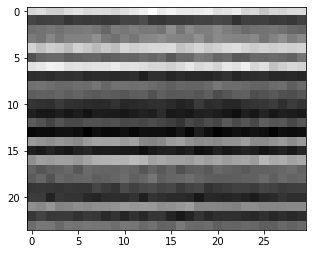

<Figure size 432x288 with 0 Axes>

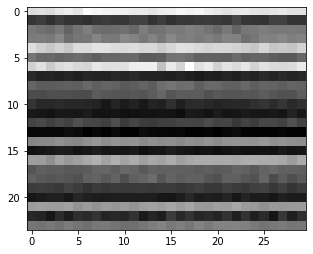

<Figure size 432x288 with 0 Axes>

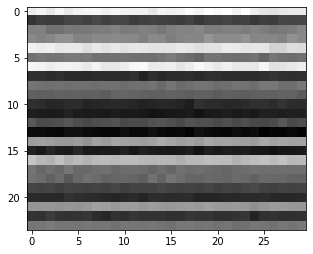

<Figure size 432x288 with 0 Axes>

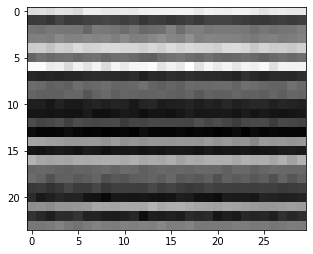

<Figure size 432x288 with 0 Axes>

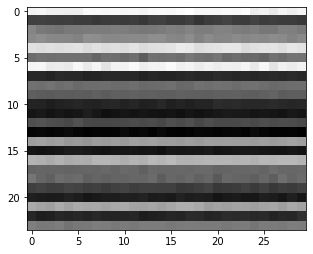

<Figure size 432x288 with 0 Axes>

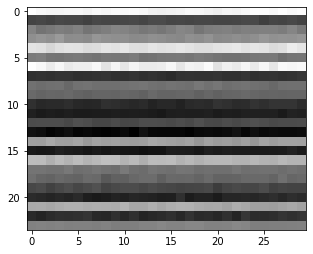

<Figure size 432x288 with 0 Axes>

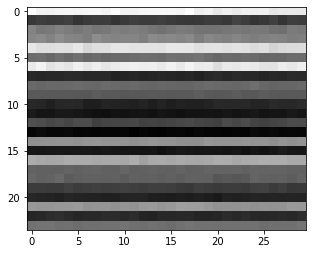

<Figure size 432x288 with 0 Axes>

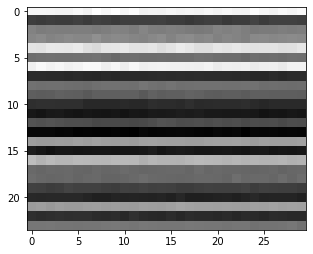

<Figure size 432x288 with 0 Axes>

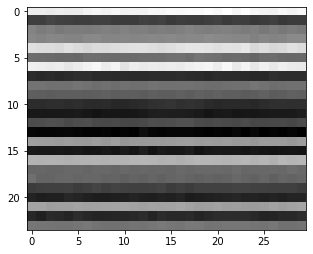

<Figure size 432x288 with 0 Axes>

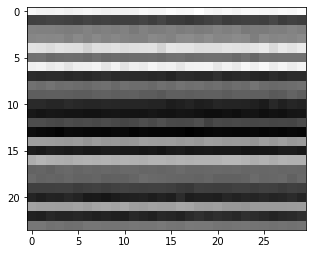

<Figure size 432x288 with 0 Axes>

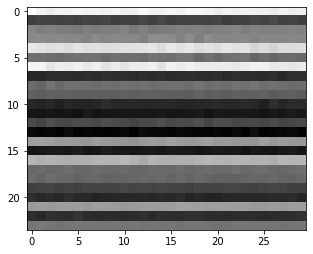

<Figure size 432x288 with 0 Axes>

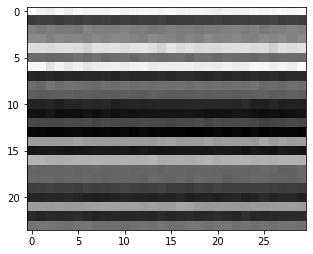

<Figure size 432x288 with 0 Axes>

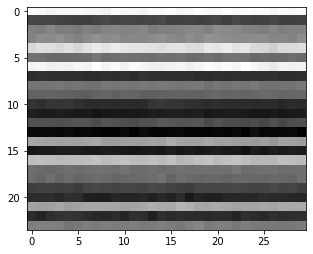

<Figure size 432x288 with 0 Axes>

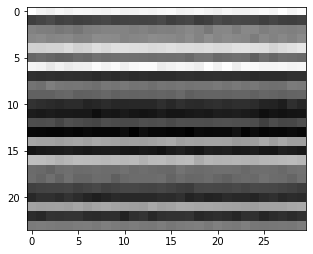

<Figure size 432x288 with 0 Axes>

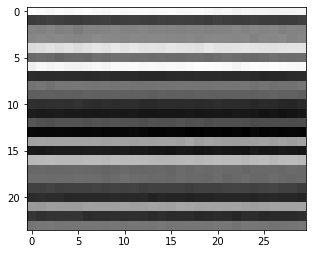

<Figure size 432x288 with 0 Axes>

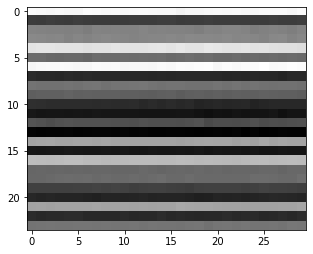

<Figure size 432x288 with 0 Axes>

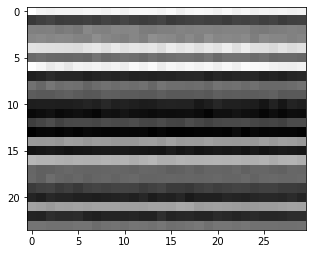

<Figure size 432x288 with 0 Axes>

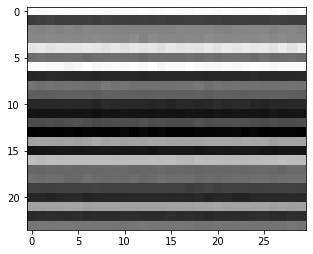

<Figure size 432x288 with 0 Axes>

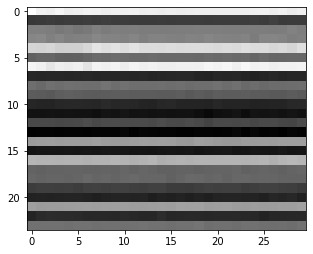

<Figure size 432x288 with 0 Axes>

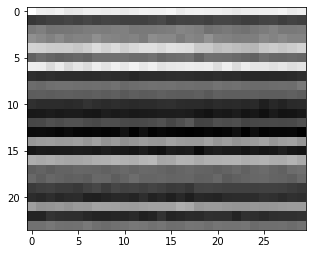

<Figure size 432x288 with 0 Axes>

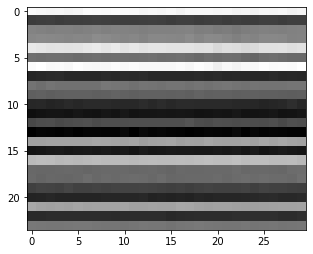

<Figure size 432x288 with 0 Axes>

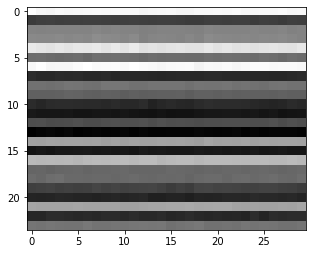

<Figure size 432x288 with 0 Axes>

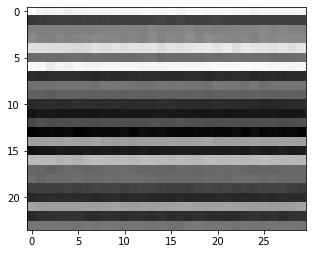

<Figure size 432x288 with 0 Axes>

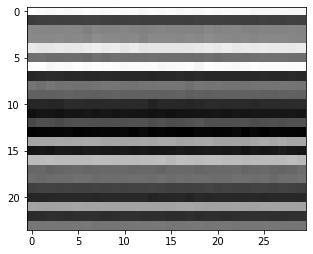

<Figure size 432x288 with 0 Axes>

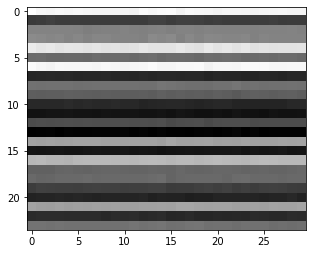

<Figure size 432x288 with 0 Axes>

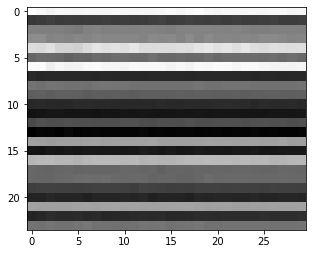

<Figure size 432x288 with 0 Axes>

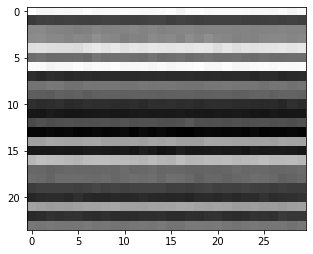

<Figure size 432x288 with 0 Axes>

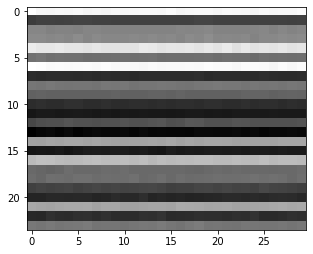

<Figure size 432x288 with 0 Axes>

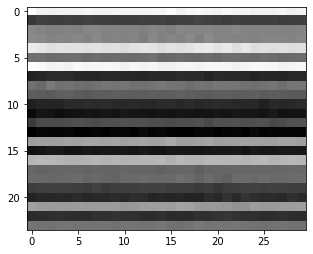

<Figure size 432x288 with 0 Axes>

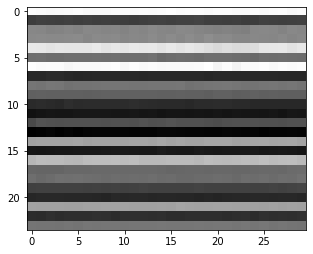

<Figure size 432x288 with 0 Axes>

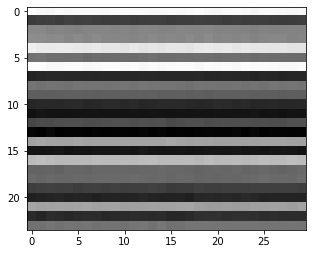

<Figure size 432x288 with 0 Axes>

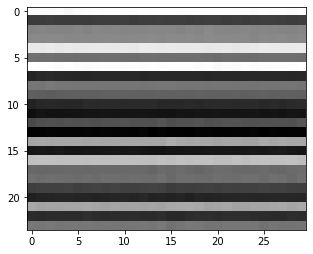

<Figure size 432x288 with 0 Axes>

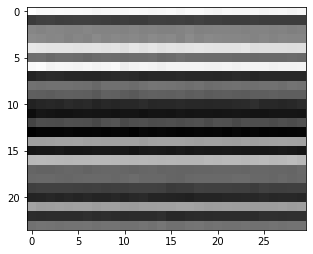

<Figure size 432x288 with 0 Axes>

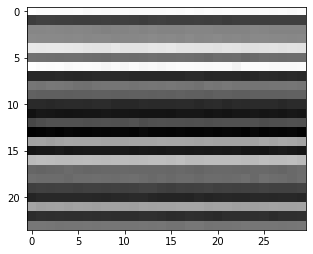

<Figure size 432x288 with 0 Axes>

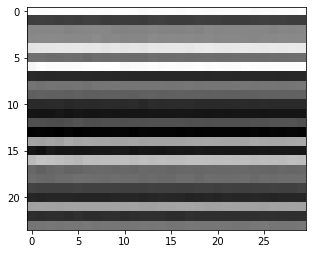

<Figure size 432x288 with 0 Axes>

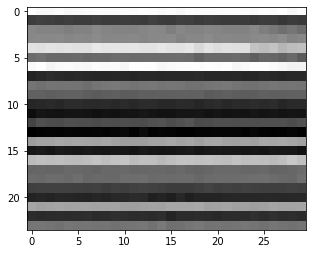

<Figure size 432x288 with 0 Axes>

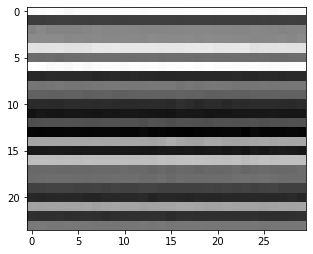

<Figure size 432x288 with 0 Axes>

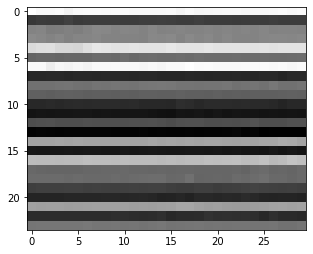

<Figure size 432x288 with 0 Axes>

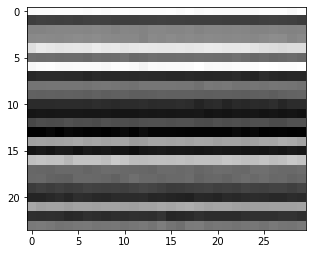

<Figure size 432x288 with 0 Axes>

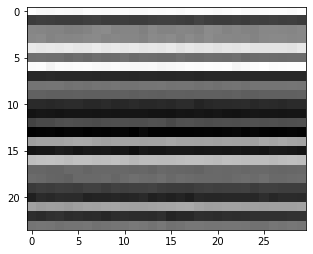

<Figure size 432x288 with 0 Axes>

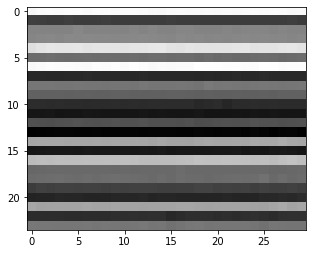

<Figure size 432x288 with 0 Axes>

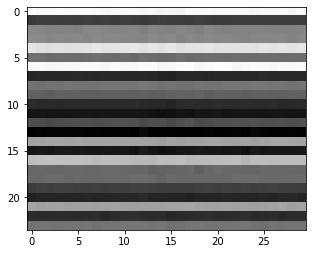

<Figure size 432x288 with 0 Axes>

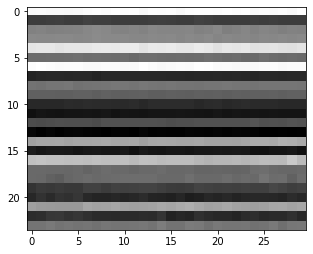

<Figure size 432x288 with 0 Axes>

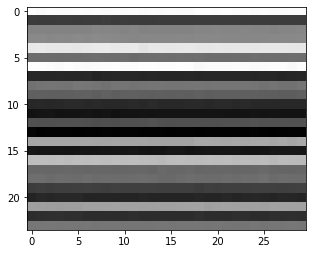

<Figure size 432x288 with 0 Axes>

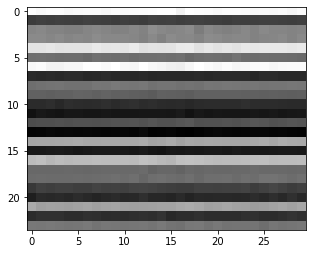

<Figure size 432x288 with 0 Axes>

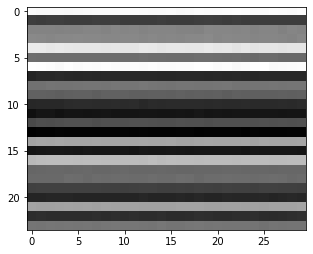

<Figure size 432x288 with 0 Axes>

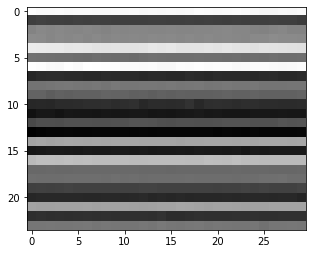

<Figure size 432x288 with 0 Axes>

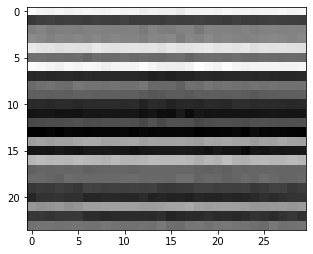

<Figure size 432x288 with 0 Axes>

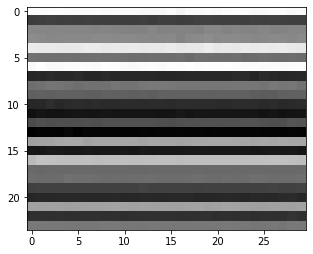

<Figure size 432x288 with 0 Axes>

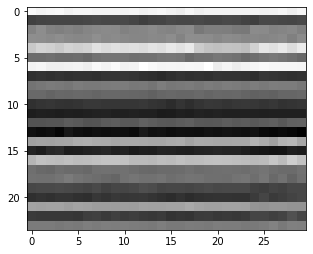

<Figure size 432x288 with 0 Axes>

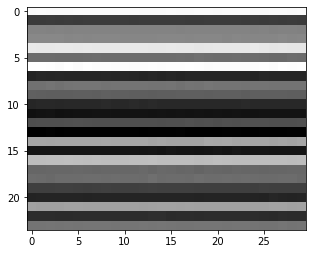

<Figure size 432x288 with 0 Axes>

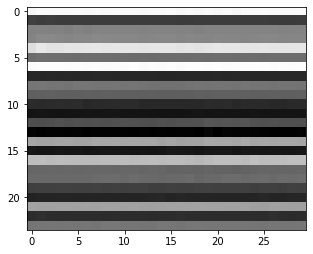

<Figure size 432x288 with 0 Axes>

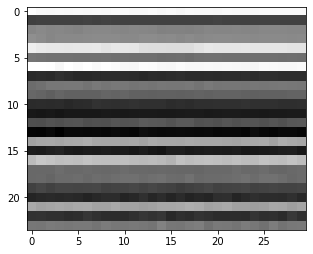

<Figure size 432x288 with 0 Axes>

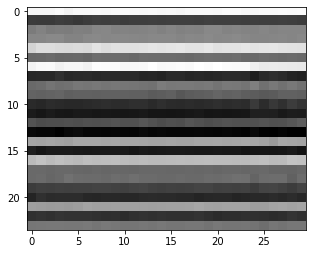

<Figure size 432x288 with 0 Axes>

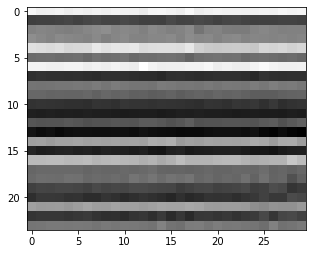

<Figure size 432x288 with 0 Axes>

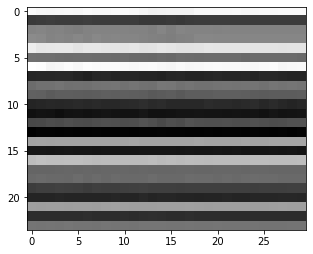

<Figure size 432x288 with 0 Axes>

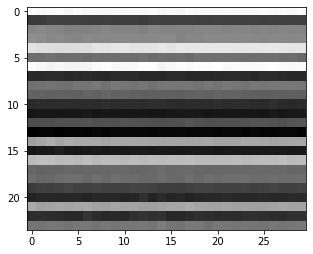

<Figure size 432x288 with 0 Axes>

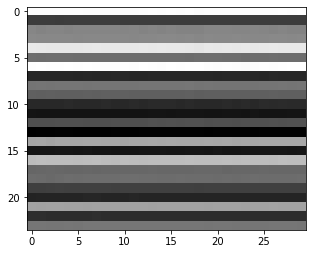

<Figure size 432x288 with 0 Axes>

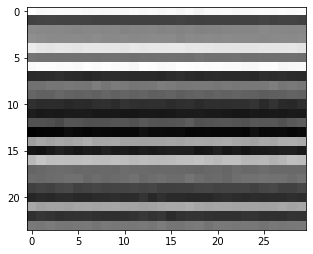

<Figure size 432x288 with 0 Axes>

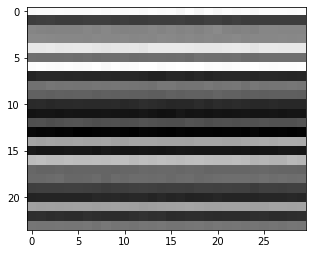

<Figure size 432x288 with 0 Axes>

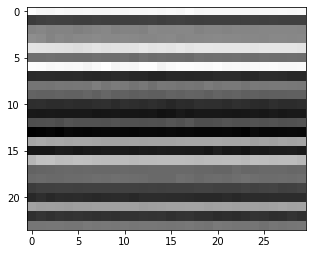

<Figure size 432x288 with 0 Axes>

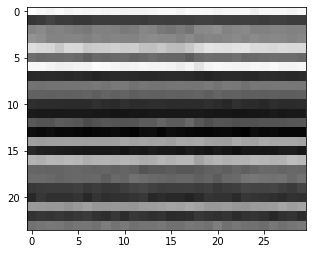

<Figure size 432x288 with 0 Axes>

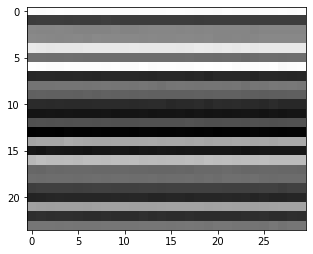

<Figure size 432x288 with 0 Axes>

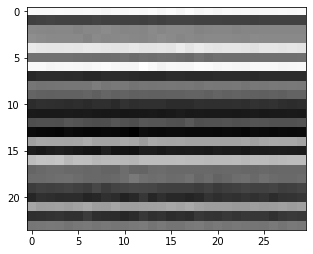

<Figure size 432x288 with 0 Axes>

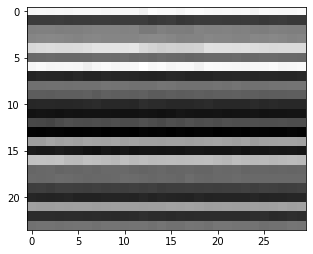

<Figure size 432x288 with 0 Axes>

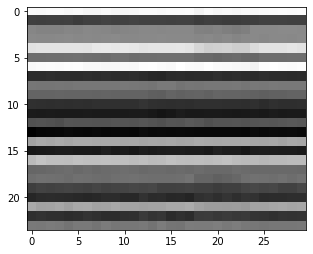

<Figure size 432x288 with 0 Axes>

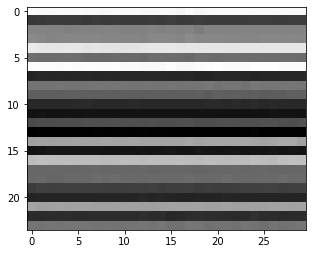

<Figure size 432x288 with 0 Axes>

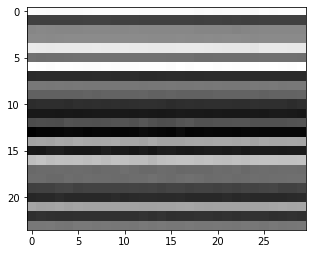

<Figure size 432x288 with 0 Axes>

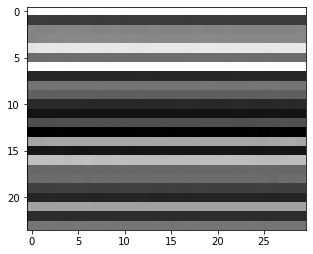

<Figure size 432x288 with 0 Axes>

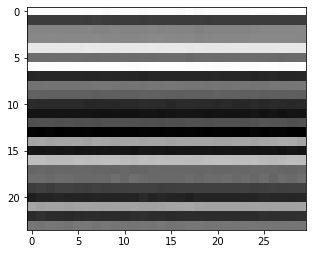

<Figure size 432x288 with 0 Axes>

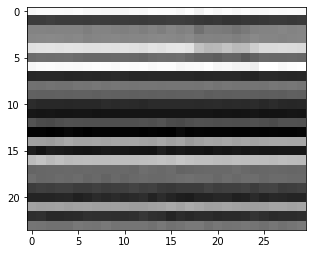

<Figure size 432x288 with 0 Axes>

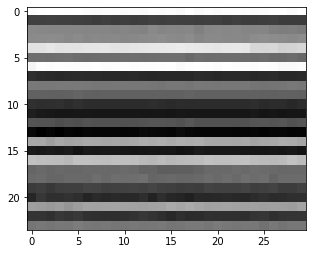

<Figure size 432x288 with 0 Axes>

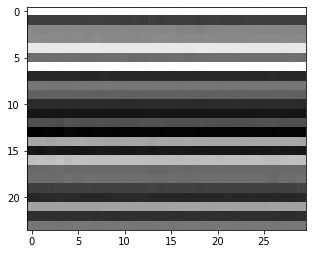

<Figure size 432x288 with 0 Axes>

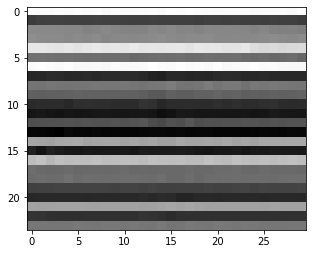

<Figure size 432x288 with 0 Axes>

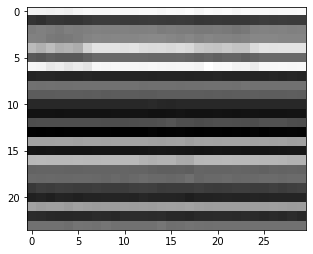

<Figure size 432x288 with 0 Axes>

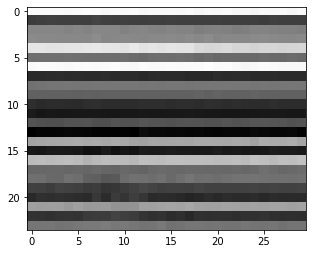

<Figure size 432x288 with 0 Axes>

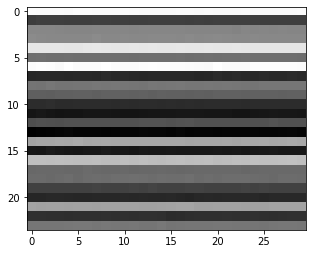

<Figure size 432x288 with 0 Axes>

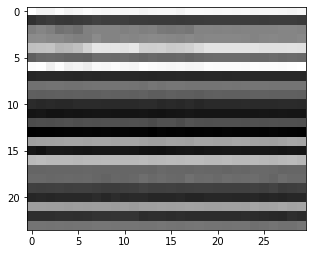

<Figure size 432x288 with 0 Axes>

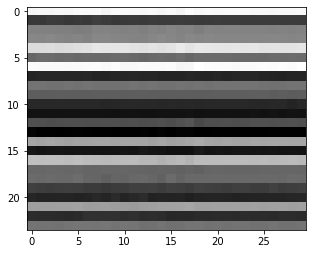

<Figure size 432x288 with 0 Axes>

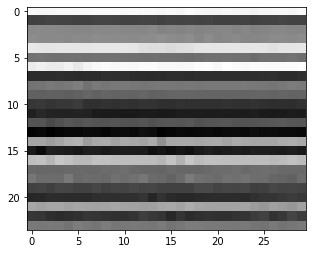

<Figure size 432x288 with 0 Axes>

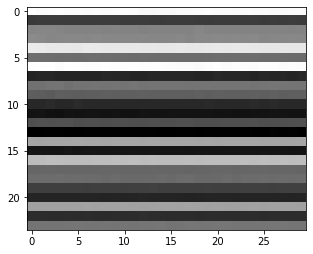

<Figure size 432x288 with 0 Axes>

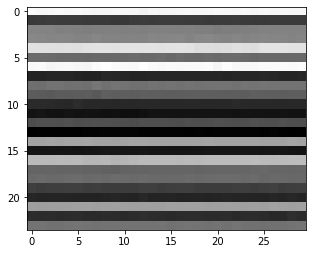

<Figure size 432x288 with 0 Axes>

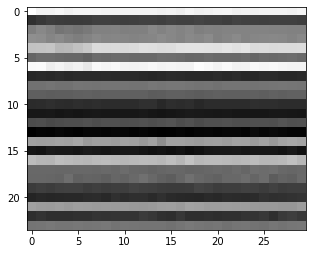

<Figure size 432x288 with 0 Axes>

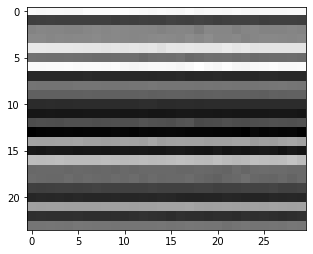

<Figure size 432x288 with 0 Axes>

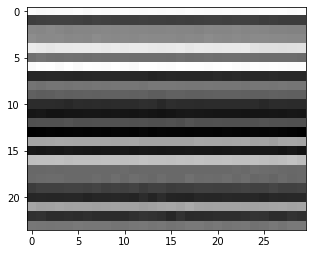

<Figure size 432x288 with 0 Axes>

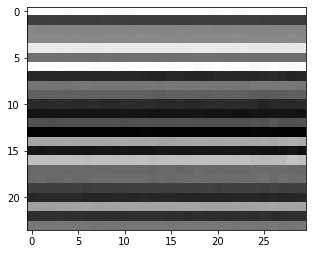

<Figure size 432x288 with 0 Axes>

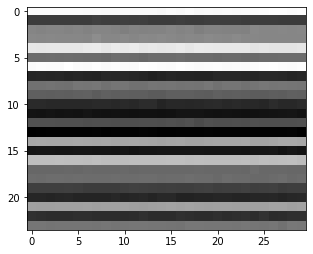

<Figure size 432x288 with 0 Axes>

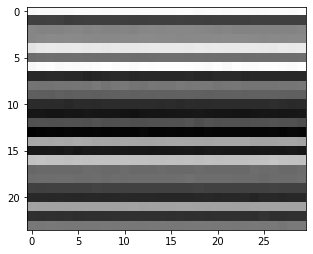

<Figure size 432x288 with 0 Axes>

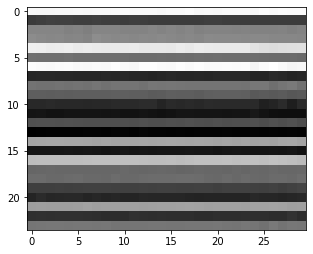

<Figure size 432x288 with 0 Axes>

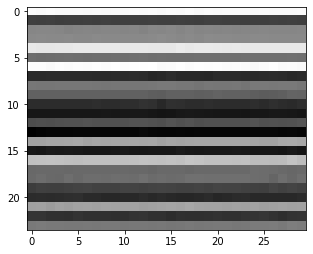

<Figure size 432x288 with 0 Axes>

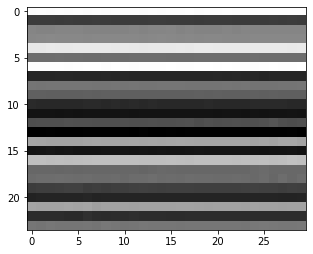

<Figure size 432x288 with 0 Axes>

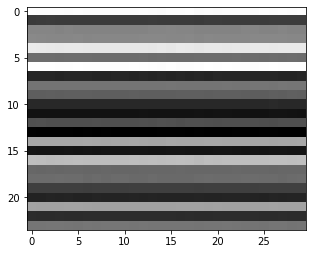

<Figure size 432x288 with 0 Axes>

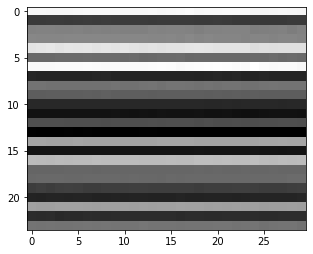

<Figure size 432x288 with 0 Axes>

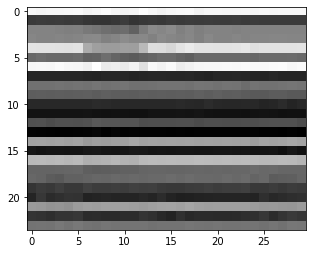

<Figure size 432x288 with 0 Axes>

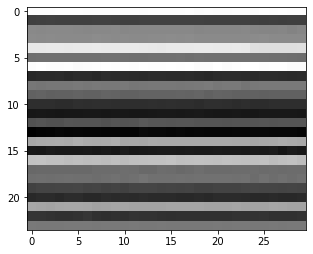

<Figure size 432x288 with 0 Axes>

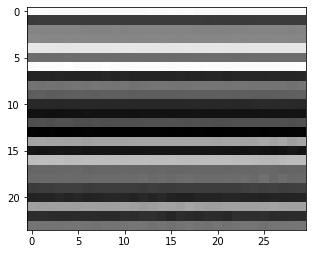

<Figure size 432x288 with 0 Axes>

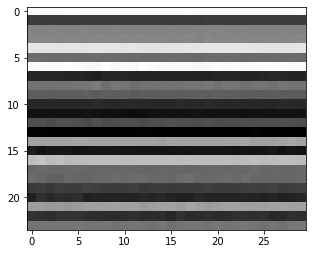

<Figure size 432x288 with 0 Axes>

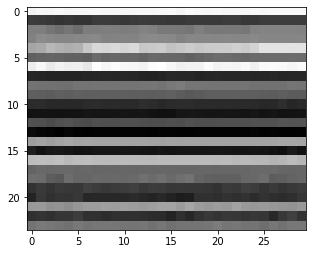

<Figure size 432x288 with 0 Axes>

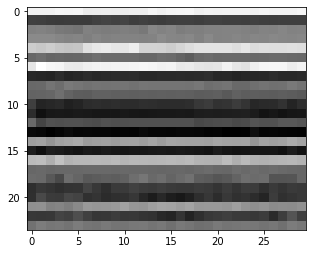

<Figure size 432x288 with 0 Axes>

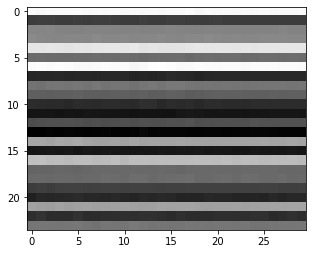

In [10]:
model.train_model(
    x_train = data_alt_3_4,     
    keep_prob = 0.5, #0.5
    train_epoch = 5000, #17000
    n_critic = 5,#5
    step_valid = 50, #50
    step_save_data = 500, #500
    iteration_generator = 400,
    )

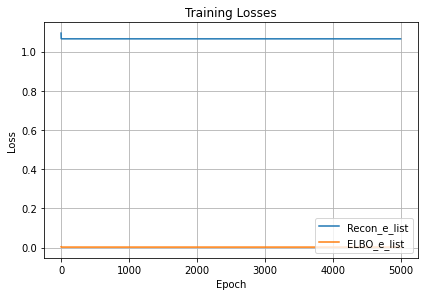

In [11]:
model.show_train_hist()

# Generating data

In [12]:
# class election_GAN_GEN(object):
#     def __init__(self,
#                 dim_height = None,
#                 dim_width = None,
#                 dim_z = None,
#                 num_class = None,
#                 batch_size = None,):
        
#         # Definition Params:
#         self.dim_height = dim_height    
#         self.dim_width = dim_width  
#         self.dim_z = dim_z    
#         self.num_class = num_class      
#         self.batch_size = batch_size  

#         # Define Network Input:
#         self.Z = tf.placeholder(tf.float32, shape=(None, 1, 1, self.dim_z))
#         self.Y_label = tf.placeholder(tf.float32, shape=(None, 1, 1, self.num_class))

#         # Network:
#         self._GEN(self.Z, self.Y_label)

#         # get the generated data
#         with tf.variable_scope('object_cost_function', reuse=tf.AUTO_REUSE):
#             self.call_GEN()
        
#     def _GEN(self, Z, Y_label):            
#         keep_prob_feed = 1
#         isTrain=False 
#         dim = 128
        
#         with tf.variable_scope("GEN", reuse=False):
#             # concat layer
#             Z_ = tf.concat([Z, Y_label], 3)  #(batch_szie, 1, 1, dim_z + num_class)
#             Z_ = tf.reshape(Z_, (-1, self.dim_z + self.num_class))        

#             # FCN 
#             hidden = tf.layers.dense(Z_, units = 2*2*3*dim)
#             hidden = tf.layers.batch_normalization(hidden, training=isTrain)
#             hidden = tf.nn.relu(hidden)
#             hidden = tf.reshape(hidden, (-1, 2, 2, 3*dim)) 

#             # CNN 1 
#             hidden = tf.layers.conv2d_transpose(hidden, 2*dim, [3, 3], strides=(1, 2), padding='valid')
#             hidden = tf.layers.batch_normalization(hidden, training=isTrain)
#             hidden = tf.nn.relu(hidden)

#             # CNN 2 
#             hidden = tf.layers.conv2d_transpose(hidden, 1*dim, [3, 3], strides=(3, 3), padding='same')
#             hidden = tf.layers.batch_normalization(hidden, training=isTrain)
#             hidden = tf.nn.relu(hidden)     

#             # CNN 3 
#             hidden = tf.layers.conv2d_transpose(hidden, 1, [3, 3], strides=(2, 2), padding='same')         
#             output = hidden

#             return output     
    
#     def call_GEN(self):
#         self.fake_output = self._GEN(self.Z, self.Y_label)

#     def GEN_model(self, path, iteration): 
    
#         saver = tf.train.Saver()

#         gpu_options = tf.GPUOptions(allow_growth=True)
#         with tf.Session(config=tf.ConfigProto(gpu_options=gpu_options)) as sess:
#             saver.restore(sess, tf.train.latest_checkpoint(path))      
            
#             generated_3alt = []
#             generated_4alt = []  
            
#             for _ in range(iteration): 
#                 '''#############        Generator          #######################'''
#                 ############        num_alternative = 3      #######################
#                 z_ = np.random.normal(0, 1, (self.batch_size, 1, 1, self.dim_z))   
#                 y_ = np.zeros([self.batch_size, 1]) + 0
#                 y_label_ = one_hot(y_, self.num_class).reshape([self.batch_size, 1, 1, self.num_class])

#                 output_g_alt3 = sess.run([self.fake_output], feed_dict={self.Z: z_, self.Y_label: y_label_})    
#                 output_g_alt3_ = np.array(output_g_alt3).reshape([self.batch_size, self.dim_height, self.dim_width])
#                 generated_3alt.append(output_g_alt3_)
                
#                 ############        num_alternative = 4      #######################
#                 z_ = np.random.normal(0, 1, (self.batch_size, 1, 1, self.dim_z))   
#                 y_ = np.zeros([self.batch_size, 1]) + 1
#                 y_label_ = one_hot(y_, self.num_class).reshape([self.batch_size, 1, 1, self.num_class])

#                 output_g_alt4 = sess.run([self.fake_output], feed_dict={self.Z: z_, self.Y_label: y_label_})  
#                 output_g_alt4_ = np.array(output_g_alt4).reshape([self.batch_size, self.dim_height, self.dim_width])
#                 generated_4alt.append(output_g_alt4_)

#             generated_3alt = np.array(generated_3alt).reshape([iteration*self.batch_size, self.dim_height, self.dim_width])
#             generated_4alt = np.array(generated_4alt).reshape([iteration*self.batch_size, self.dim_height, self.dim_width])
                
#             return generated_3alt, generated_4alt

In [13]:
# tf.reset_default_graph()

In [14]:
# generator = election_GAN_GEN(
#                 dim_height = dim_height,
#                 dim_width = dim_width,
#                 dim_z = dim_z,
#                 num_class = num_class,
#                 batch_size = batch_size)


shape[0]: number of generated data

shape[1], shape[2]: data size before resize back to original size

In [15]:
# iteration_generator = 50
# gen_alt3, gen_alt4 = generator.GEN_model(path = restore_path, 
#                                          iteration = iteration_generator) #iteration: how many times generator is used?
# print(gen_alt3.shape) 
# print(gen_alt4.shape)

In [16]:
# plt.figure(1)
# fig, ax = plt.subplots(figsize=(5, 5))
# ax.cla()
# ax.imshow(np.reshape(gen_alt3[0], (dim_height, dim_width)), cmap='gray')

# fig, ax = plt.subplots(figsize=(5, 5))
# ax.cla()
# ax.imshow(np.reshape(gen_alt4[0], (dim_height, dim_width)), cmap='gray')            
# plt.show()

# Resize to original shpe & Save as CSV

In [17]:
# def resize_to_ori(x, img_size, img_width, img_height, ori_size):
#     x = x.reshape([iteration_generator*batch_size, img_width*img_height])
#     cell_size = int(img_size//ori_size)

#     ori_dat = []
#     for j in range(x.shape[0]):
#         dat = x[j]
#         tmp = []
#         for i in range(dat.shape[0] // cell_size):
#             k = dat[(i)*cell_size:(i+1)*cell_size]
#             tmp.append(np.mean(k))
#         ori_dat.append(tmp)
#     ori_dat = np.array(ori_dat)    
#     return ori_dat

In [18]:
# img_size = np.math.factorial(6)
# img_width = 30
# img_height = 24
# ori_size = np.math.factorial(3)

# gen_alt3_ori = resize_to_ori(gen_alt3, img_size, img_width, img_height, ori_size)
# gen_alt3_pd = pd.DataFrame(gen_alt3_ori, columns = ['ABC', 'ACB', 'BAC', 'BCA', 'CAB', 'CBA'])
# print(gen_alt3_pd.shape)
# gen_alt3_pd.head()

In [19]:
# gen_alt3_pd.to_csv(generated_path + 'generated_atl3.csv')

In [20]:
# img_size = np.math.factorial(6)
# img_width = 30
# img_height = 24
# ori_size = np.math.factorial(4)

# gen_alt4_ori = resize_to_ori(gen_alt4, img_size, img_width, img_height, ori_size)
# gen_alt4_pd = pd.DataFrame(gen_alt4_ori, columns = ['ABCD', 'ACBD', 'BACD', 'BCAD', 'CABD', 'CBAD', 'DABC',
#        'DACB', 'DBAC', 'DBCA', 'DCAB', 'DCBA', 'ADBC', 'ADCB', 'BDAC', 'BDCA',
#        'CDAB', 'CDBA', 'ABDC', 'ACDB', 'BADC', 'BCDA', 'CADB', 'CBDA'])
# print(gen_alt4_pd.shape)
# gen_alt4_pd.head()

In [21]:
# gen_alt4_pd.to_csv(generated_path + 'generated_atl4.csv')